# 42186 Model-based machine learning - Project
#### A. Emilie J. Wedenborg (s164535) - Iben Fjord Kjærsgaard S164529 - Sif Ingibergsdóttir Novitski (s144510)

## Table of content

| Main Content | Sub-content | Contributions | 
| :--- | :--- | :---|
| 1. Introduction | | Emilie|
| 2. Data preparation, insights and visualization |  | | 
|  | 2.1 Data preparation |Iben  |
|  | 2.2 Visualization | Sif |
|  | 2.3 Insights from the data and analysis of patterns | Emilie |
| 3. Modelling |  |  | 
|  | 3.1 Data model preparation | Iben |
|  | 3.2 Model 1 - Basic Autoregressive Model (BA) | Sif |
|  | 3.3 Model 2 - Manual change points model (BAC)| Emilie |
|  | 3.4 Model 3 - Vector autoregressive model (VA)| Iben |
|  | 3.5 Model 4 - Change point & vector autoregression model (VAC)| Sif |

All students contributed to the design of structure and provided constructive feedback to all sections of the project equally. 


## 1. Introduction



The notebook is written as project report for the course 42186 Model-based machine learning in spring 2020.

This project will use the COVID-19 dataset from John Hopkins University* in the hopes of modelling the spread of the virus. 
This is highly relevant as the Corona virus represents a global treath with more than 188.000 death worldwide. 
The data set we will be working with contains 3 time series: Confirmed, death and recovered for various countries. In this project we will be focusing on the spread of the COVID-19 virus in the United states. 

A vector auto regressive model with hidden states and a change point will be used on the data to predict the spread of corona and to enable a shift of regime before and after this change point. Before this model is implemented, simpler models are developed before in order to understand the dynamical system.
The first model will only focus on the confirmed, and not on the recovered or deaths and is a simple auto regressive model. Afterwards different models will be tried to gain a deeper understanding of the hyperparameters and then the model complexity can be increased gradually until the final model is reached. 


#### Project delimination 
The aim of this project is to predict the spread of the COVID-19 virus in the united states and see if we can track when political inititives was implemented by the US government or other influencing factors that could affect the spread of the virus. 


_*"This is the data repository for the 2019 Novel Coronavirus Visual Dashboard operated by the Johns Hopkins University Center for Systems Science and Engineering (JHU CSSE). Also, Supported by ESRI Living Atlas Team and the Johns Hopkins University Applied Physics Lab (JHU APL)." (https://github.com/CSSEGISandData/COVID-19/tree/master/csse_covid_19_data/csse_covid_19_time_series)_






#### Comparison 

A quanitative measurement will be used to evaluate and compare the models. The *Root Mean Square Error* (RMSE) have been chosen, which is the sample standard deviation of the differences between predicted values and observed values. 

\begin{equation*}
RMSE = \sqrt{\frac{1}{n}\Sigma_{i=1}^{n}{(y_i-\hat{y_i})^2}}
\end{equation*}

The RMSE is sensitive to outliers, since it penalises higher difference more. Thus, the RMSE is useful when large errors are particularly undesirable, which it is in this project.


## 2. Data preparation, insights and visualization
The data consits of three time series which are: 
* Confirmed: Confirmed cases include presumptive positive cases.
* Deaths: Death totals in the US include confirmed and probable, in accordance with CDC guidelines as of April 14.
*Recovered: Recovered cases outside China are estimates based on local media reports, and state and local reporting when available, and therefore may be substantially lower than the true number.
 (https://github.com/CSSEGISandData/COVID-19/tree/master/csse_covid_19_data/csse_covid_19_time_series)

### 2.1 Data preparation


In this section the originally data for number of death, confirmed and recovered are loaded. Furthermore, the data is modified so it has the right format. 

Useful packages are imported:

In [0]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn import linear_model
from sklearn.metrics import mean_squared_error  
import pystan
# fix random generator seed (for reproducibility of results)
np.random.seed(42)
pd.options.display.float_format = "{:.2f}".format
# matplotlib style options
plt.style.use('ggplot')
%matplotlib inline
# SLET NEDENUNDER
#plt.rc('xtick',labelsize=15)
#plt.rc('ytick',labelsize=15)
#plt.rcParams['axes.labelsize'] = 15
#plt.rcParams['axes.titlesize'] = 15
#plt.rcParams['axes.titlesize'] = 15

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Data for Confirmed, Death and Recovered are loaded from a Github repository. The data is then filtered for a country and in this report US is chosen country. Then the cumulative values is transformed to deltas values for the Confirmed, Death and Recovered cases. 

In [0]:
def get_data(url, dataset, Country,start_date, end_date):
  """The code loads the data from a URL path. Then the data is filtered according
    to the chosen filtered and transformed. """
  # Loading data
  data = pd.read_csv(url,index_col=0,error_bad_lines=False).reset_index()
  
  #Filtering the data according to the chosen country and transforming it
  df = (data.loc[data['Country/Region'] == Country].set_index(['Province/State', 'Country/Region','Lat','Long'])
            .stack()
            .rename_axis(['Province/State', 'Country/Region','Lat','Long','Date'])
            .reset_index(name= dataset)
            ).drop(columns = ['Province/State', 'Country/Region', 'Lat','Long'])
  
  #The date column gets a date format. 
  df['Date'] = pd.to_datetime(df.Date, format = '%m/%d/%y')
  
  #Calculating the delta values from the cumulative values for each case.
  if dataset == 'Confirmed':
    df['Confirmed_delta'] = df['Confirmed'].diff()
    df.loc[0,'Confirmed_delta'] = df.loc[0,'Confirmed']
    df['Confirmed_delta'] = df['Confirmed_delta'].astype(int)
  elif dataset == 'Deaths':
    df['Deaths_delta'] = df['Deaths'].diff()
    df.loc[0,'Deaths_delta'] = df.loc[0,'Deaths']
    df['Deaths_delta'] = df['Deaths_delta'].astype(int)
  elif dataset == 'Recovered':
    df['Recovered_delta'] = df['Recovered'].diff()
    df.loc[0,'Recovered_delta'] = df.loc[0,'Recovered']
    df['Recovered_delta'] = df['Recovered_delta'].astype(int)

  # Filtering the data according to the chosen start and end date
  mask = (df['Date'] >= start_date) & (df['Date'] <= end_date)
  df = df.loc[mask]
  return df 


As we have been working continously with the data, we have defined a end date, after which we will no longer be working with the data. The start and end date are set to: 

In [0]:
StartDate = '2020-01-22'
EndDate = '2020-05-10'

Loading the Confirmed cases data for the US. 

In [0]:
url_confirmed = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv'
df_confirmed = get_data(url_confirmed, 'Confirmed', 'US',StartDate , EndDate)
df_confirmed.head(2)

Date  Confirmed  Confirmed_delta
0 2020-01-22          1                1
1 2020-01-23          1                0

Loading the Deaths cases data for the US.

In [0]:
url_deaths = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv'
df_deaths = get_data(url_deaths, 'Deaths','US',StartDate , EndDate)
df_deaths.head(2)

Date  Deaths  Deaths_delta
0 2020-01-22       0             0
1 2020-01-23       0             0

Loading the Recovered cases data for the US.

In [0]:
url_recovered = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv'
df_recovered = get_data(url_recovered, 'Recovered', 'US',StartDate , EndDate)
df_recovered.head(2)

Date  Recovered  Recovered_delta
0 2020-01-22          0                0
1 2020-01-23          0                0

#### Merging the data
The data for Confirmed, Deaths and Recovered cases are merged together

In [0]:
data_temp = pd.merge(df_confirmed, df_deaths, on=['Date'])
data = pd.merge(data_temp, df_recovered, on=['Date'])
data.head()

Date  Confirmed  ...  Recovered  Recovered_delta
0 2020-01-22          1  ...          0                0
1 2020-01-23          1  ...          0                0
2 2020-01-24          2  ...          0                0
3 2020-01-25          2  ...          0                0
4 2020-01-26          5  ...          0                0

[5 rows x 7 columns]

### 2.2 Visualization
To get a clear idea about the progression in the number of Confirmed, Recovered and Death cases a figure is made for  the Delta as a function of days. 

In [0]:
# Defining color codes
color_confirmed = 'blue'
color_deaths = 'red'
color_recovered = 'green'
color_estimated = 'black'
color_1std = 'grey'
color_2std = 'silver'
color_combined = [color_confirmed,color_deaths,color_recovered]

INFO:numexpr.utils:NumExpr defaulting to 2 threads.


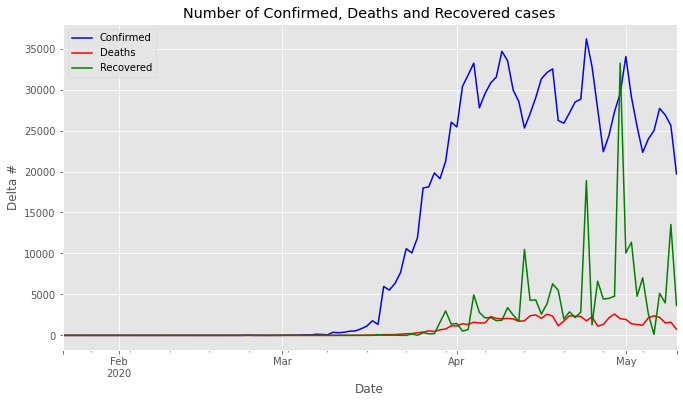

In [0]:
plt.rcParams["figure.figsize"] = (11,6)
data.plot(x ='Date', y=['Confirmed_delta','Deaths_delta','Recovered_delta'], 
               kind = 'line', legend = True, subplots = False, color = color_combined)
plt.legend(['Confirmed','Deaths','Recovered'])
plt.xlabel('Date')
plt.ylabel('Delta #')
plt.title('Number of Confirmed, Deaths and Recovered cases') 
plt.show()

The above figure clearly illustrate an exponential increasment of confirmed cases around start of March where around April it becomes more steady but very fluctuating. The number of cases of Death and recovered are approximetly 2 weeks behind the confirmed. The figure also illustarte that the number of recovered cases are also very fluctuating and more people are recovering compared to the number of death people. 

### 2.3 Insights from the data and analysis of patterns

To get an overview of the data a general statistics is made. Furthermore, a correlation table is also made to investigate whether the columns are correlated. 

In [0]:
print("General statistics:")
data.describe()

General statistics:


Confirmed  Confirmed_delta  ...  Recovered  Recovered_delta
count     110.00           110.00  ...     110.00           110.00
mean   298182.21         12084.18  ...   33426.88          1965.17
std    427512.00         13573.42  ...   59885.56          4326.90
min         1.00             0.00  ...       0.00             0.00
25%        13.00             1.00  ...       3.00             0.00
50%      5549.00          1234.50  ...      17.00             2.50
75%    574296.25         26734.25  ...   40858.50          2575.25
max   1329260.00         36188.00  ...  216169.00         33227.00

[8 rows x 6 columns]

The general statistic highlight the high number of Confirmed cases (1,329,260) compared with the numbers of Death (79,526) and Recovered (216,169). Meaning that there is probabaly a delay in the number of Death and Recovered cases. Combined with the posibility that not all confirmed cases 
has been followed up on. 
Furthermore, the table fortunately also shows that the recovering rate must be heigher than the death rate, since there are more than twice as many Recovered cases than Death cases.

To get a better insight in the data the delta variables Confirmed, Deaths and Recovered will be examined for any correlation.

In [0]:
corr = data[['Confirmed_delta','Deaths_delta','Recovered_delta']].corr()


To illustarte the correlation better the following code is used, which was found in answer 29 on the following site: 
https://datascience.stackexchange.com/questions/10459/calculation-and-visualization-of-correlation-matrix-with-pandas



In [0]:

cmap = cmap=sns.diverging_palette(5, 250, as_cmap=True)
def magnify():
    return [dict(selector="th",
                 props=[("font-size", "7pt")]),
            dict(selector="td",
                 props=[('padding', "0em 0em")]),
            dict(selector="th:hover",
                 props=[("font-size", "12pt")]),
            dict(selector="tr:hover td:hover",
                 props=[('max-width', '200px'),
                        ('font-size', '12pt')])
]

corr.style.background_gradient(cmap, axis=1)\
    .set_properties(**{'max-width': '80px', 'font-size': '10pt'})\
    .set_caption("Hover to magify")\
    .set_precision(2)\
    .set_table_styles(magnify())

The figure shows a high positive correlation between the variables Confirmed and Deaths, which was also expected, since Deaths cases depends on the Confirmed cases. Notably, the Recovered cases have a relative low correlation to confirmed compared to deaths, which intuitively sould be approximetly the same, since they both depends on the confirmed cases. 

## 3. Modelling
There are defined 4 models, which will consist of an introduction, modelling, result, discussion and a conclusion.
Each model is a learning proces and inspire the next model 


### 3.1 Data model preperation


The data is split into a Training and Test set. 
*   Training set is consist of the delta numbers from 22 January to 20 April.
*   Test set is consist of the delta numbers from 21 April to 10 May.
 

In [0]:
Train_StartDate = '2020-01-22'
Train_EndDate = '2020-04-20'

In [0]:
# Defining the Training data according to the chosen dates. 
mask_train = (data['Date'] >= Train_StartDate) & (data['Date'] <= Train_EndDate)
# Convert data to a matrix
y_train = data[['Confirmed_delta','Deaths_delta','Recovered_delta']].loc[mask_train].values
# The Training set ranges
ix_train = range(0,len(y_train)) 
# The Traning set dates 
y_train_dates = data[['Date']].loc[mask_train] 

In [0]:
# Defining the Test data according to the chosen dates. 
mask_test = (data['Date'] > Train_EndDate)
# Convert data to a matrix
y_test = data[['Confirmed_delta','Deaths_delta','Recovered_delta']].loc[mask_test].values
# The Test set ranges
ix_test = range(len(y_train), len(data)) 
# The Test set dates
y_test_dates = data[['Date']].loc[mask_test] 

The size of the Training and Test set

In [0]:
print("N_train:", len(ix_train))
print("N_test:", len(ix_test))


N_train: 90
N_test: 20


The models in the report uses the number of timestep to train on and the number of timestep it should predict. These values will be defined now:

In [0]:
T = len(ix_train) # Training timestep
T_forecast=len(ix_test) # Test timestep

The Confirmed, Deaths and Recovered values will be transformed by square root since it will help the model. This is due to the data having exponential growth in some places while being linear or constant in others.

The square root has a moderate effect on distribution shape and it is weaker than the logarithm. The advantage of this transformation is that it can be applied to zero values which there are in the data.



In [0]:
y_C = np.array((y_train[:,0])**(1/2)).astype(float) #Confirmed values are transformed 
y_D = np.array((y_train[:,1])**(1/2)).astype(float) #Deaths values are transformed 
y_R = np.array((y_train[:,2])**(1/2)).astype(float) #recovered values are transformed 

#### Helping functions

Two function will be made, do simplify code throughout the notebook. 
The first function is a plot function, which visualize the results from the model. 
The second function is compiling and fitting the Stan model.

In [0]:
def plot_results(cases, yhat, ystd, model_nr, change_points):

  # Specifying which case id being plotted
  if (cases == 'Confirmed'):
    nr = 0
    color_case = color_confirmed 
  elif (cases == 'Deaths'):
    nr = 1
    color_case = color_deaths
  elif (cases == 'Recovered'):
    nr = 2
    color_case = color_recovered
  
  #Plot training data 
  plt.plot(y_train_dates, y_train[:,nr], color = color_case, 
           linestyle="-", linewidth = 3, label='true (train)')
  
  #Plot test data 
  plt.plot(y_test_dates, y_test[:,nr], color = color_case, 
           marker= "x",linestyle="None",label='true (test)')
  
  #Plot estimated values 
  plt.plot(data[['Date']], yhat, color = color_estimated, 
           linestyle="-", linewidth = 1.5, label='forecast')
  
  #Plot standard deviation
  plt.plot(data[['Date']], yhat + ystd, color = color_1std, 
           linestyle="--",linewidth = 1.5, label='forecast +- stddev')
  plt.plot(data[['Date']], yhat - ystd,color = color_1std , 
           linestyle= "--",linewidth = 1.5,label='_nolegend_')

  #Plot 2 times standard deviation
  plt.plot(data[['Date']], yhat + 2*ystd, color = color_2std, 
           linestyle="--",linewidth = 1.5, label='forecast +- 2*stddev')
  plt.plot(data[['Date']], yhat - 2*ystd,color = color_2std , 
           linestyle= "--",linewidth = 1.5, label='_nolegend_')

  
  # If the plot contains change points 
  if change_points[0] != 0:
      for xc in change_points:
        line_place = data['Date'].iloc[xc]
        plt.axvline(x=line_place, color='purple', linestyle='--', 
                    label='Change point predicted')

  plt.legend()
  plt.title('Results for {0} cases using model {1}'.format(cases, model_nr),
            fontsize=12)
  plt.ylabel('# of {0}'.format(cases) )
  plt.xlabel('Dates')
  plt.xticks(rotation=45)
  #plt.show()

In [0]:
def fit_the_model(data, model):
  # create Stan model object (compile Stan model)
  sm = pystan.StanModel(model_code=model)
  fit = sm.sampling(data=data, iter=500, chains=4, 
                     algorithm="NUTS", seed=42, verbose=True)
  samples = fit.extract(permuted=True)  # return a dictionary of arrays
  
  return samples, fit


### 3.2 Model 1 - Basic Autoregressive Model (BA)



In this section the basic autoregressive model will be implemented. We chose this model because it is a simple and easy model to implement. This type of model is widely used and is therefore a good place to start. Because we are using a regression model we will be assuming that the data is continuous.  We hope to use this model as a starting point for the other models implemented in the next sections.  

For this model we will only be looking at the confirmed cases of the virus. 


#### Prior predictive sampling
Instead of doing ancestral sampling like we did in some of the lectures, we sample values from our distribution using STAN. 
This is done by eliminating the likelihood and instead sampling directly from the prior. 

The difference between the STAN code below and the one used to train the model is that we do not infer the variables in the model section, but instead sample them directly from the generated quantities block. 

This also means that the model will not be able to train on the given y values, as they will not be given as input, which will give us a better understanding of the hyper paramters and distributions. 

For the simple STAN model we have chosen to use normal distributions, as we found that these are commonly used in timeseries. 

In [0]:
# define Stan model
model_1_sampling_definition = """
data {
    int<lower=1> T;                 // length of the time-series
    int<lower=0> T_forecast;        // num. steps ahead to predict
    real<lower=0> tau_val;          // Prior to tau
    real<lower=0> sigma_val;        // Prior to sigma
    real<lower=0> beta_val;         // Prior to beta
}

parameters {
    real beta;                          // state transition coefficients
    real<lower=0> tau;                  // state transition noise
    real<lower=0> sigma;                // observation noise
    vector<lower=0>[T+T_forecast] z;    // vector of latent states
}

model {
    beta ~ normal(0,beta_val);             // prior on the auto-regressive coefficients
    tau ~ normal(0,tau_val);               // prior on the variance
    sigma ~ normal(0,sigma_val);           // prior on the variance
    
    z[1] ~ normal(0, 10);                  // fat prior on first state
    for(t in 2:(T+T_forecast)) {
        z[t] ~ normal(beta * z[t-1], tau); // latent dynamics
    }
    
}

generated quantities {

    vector[T + T_forecast] y_hat; // Vector of predictions

    for (t in (1):(T+T_forecast)) {
        y_hat[t] <- normal_rng(z[t], sigma);  // predictions
    }                                         // rng is a random number generator
}
"""


The input is prepared for sampling: 

In [0]:
# prepare data for Stan model
data_model_1_sampling = {'T': len(y_train), 'T_forecast': T_forecast,
        'tau_val':10,'sigma_val':0.1, 'beta_val':1}

The data is fitted to the model:

In [0]:
samples_model_1_sampling, fit_model_1_sampling = fit_the_model(data_model_1_sampling, model_1_sampling_definition)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_f419bf4faeeacba657db656b473a5fba NOW.


We take a closer look at the fit:

In [0]:
print(fit_model_1_sampling)

Inference for Stan model: anon_model_f419bf4faeeacba657db656b473a5fba.
4 chains, each with iter=500; warmup=250; thin=1; 
post-warmup draws per chain=250, total post-warmup draws=1000.

             mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
beta          1.0  5.3e-3   0.02   0.97   0.99   1.01   1.02   1.03     11    1.2
tau          4.64     0.8   4.24   0.62   1.51   3.13   6.29   15.9     28   1.14
sigma        0.08  2.5e-3   0.06 4.2e-3   0.04   0.08   0.11   0.24    597    1.0
z[1]         9.65    0.59   5.98   0.78    4.9   9.31  13.17  24.05    103   1.02
z[2]        11.32    0.75   7.56    1.1   5.52  10.47  15.23  29.18    102   1.03
z[3]        12.86    0.81   9.08   0.64   6.41  11.68  16.34  36.26    125   1.03
z[4]        13.95    0.95  10.87   0.54   6.79  11.88  17.77  39.64    131   1.02
z[5]        15.52     1.1  12.45   1.64   7.33  12.93  19.08  48.92    128   1.03
z[6]         16.6    1.35  14.12   1.41   7.61  13.83   20.5  55.22    110  

The fit is plotted:

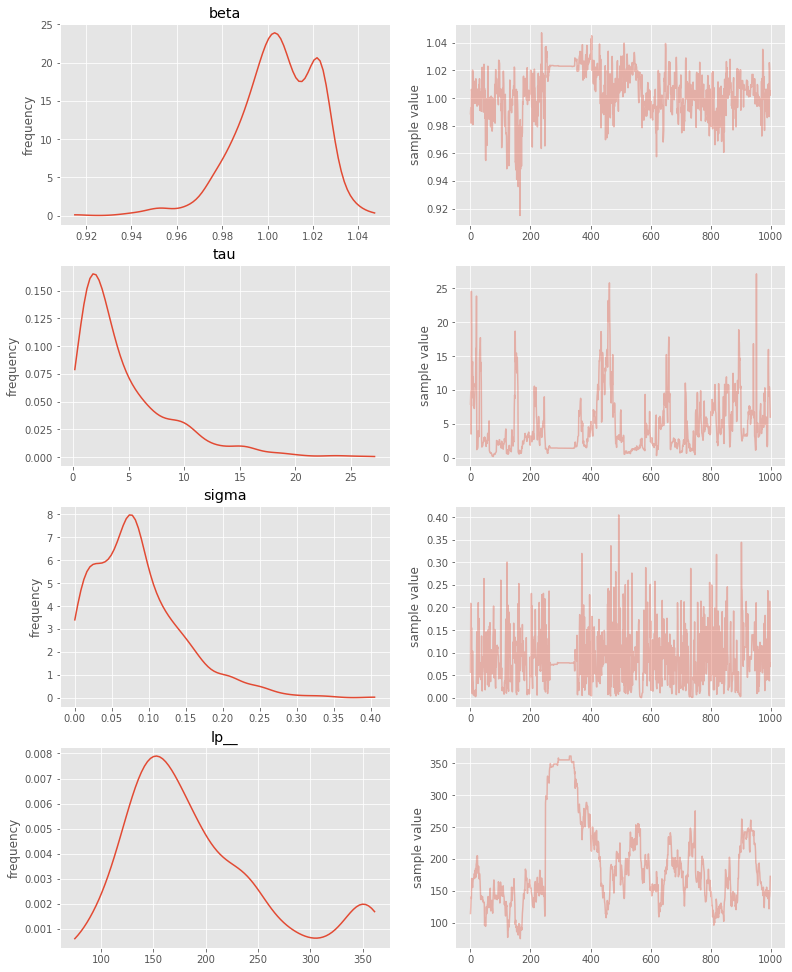

In [0]:
plt.rcParams["figure.figsize"] = (13,17)
fit_model_1_sampling.plot(["beta","tau","sigma","lp__"])
plt.show()

The samples does not look completely random sampled which indicates that there might be need of some further tuning of the hyper parameters.   

Below that mean and standard deviation is extracted from the model.

In [0]:
y_hat_model_1_sampling = (samples_model_1_sampling["y_hat"]).mean(axis=0)
y_std1_model_1_sampling = (samples_model_1_sampling["y_hat"]).std(axis=0)

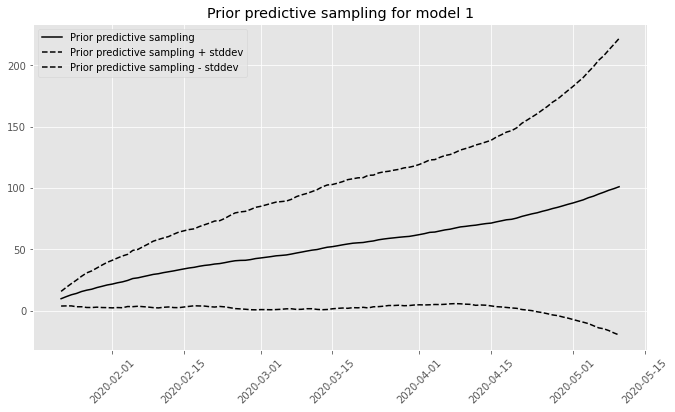

In [0]:
plt.rcParams["figure.figsize"] = (11,6)
plt.plot(data[['Date']], y_hat_model_1_sampling, color = color_estimated, linestyle="-", linewidth = 1.5)
plt.plot(data[['Date']], y_hat_model_1_sampling + y_std1_model_1_sampling, color = color_estimated, linestyle="--",linewidth = 1.5)
plt.plot(data[['Date']], y_hat_model_1_sampling - y_std1_model_1_sampling,color = color_estimated , linestyle= "--",linewidth = 1.5)
plt.xticks(rotation=45)
plt.legend(["Prior predictive sampling","Prior predictive sampling + stddev","Prior predictive sampling - stddev"])
plt.title('Prior predictive sampling for model 1')
plt.show()

Above the results are plottet. From this it can be seen that the prior predictive sampling appears to have a relatively good structure which might be able to capture the pattern in the data. We contrained z to be positive, since the data only contains positive values.
The relatively wide standard deviation should also be able to capture the irregularity of the data. 

#### Basic Autoregressive model
First the model is implemeted in STAN. Here we have chosen all our distributions as normal distributions. 
As it can be seen the model is inspired from a hidden markov model due to an implementation of a hidden state. In addition, it predicts the next value using the previous timepoint. 

\begin{align}
z_t &\sim \mathcal{N}(\beta_1 z_{t-1} , \tau^2)\\
y_t &\sim \mathcal{N}(z_t, \sigma^2)
\end{align}

In [0]:
# define Stan model
model_1_definition = """
data {
    int<lower=1> T;            // length of the time-series
    int<lower=0> T_forecast;   // num. steps ahead to predict
    real y[T];                 // time-series data
    real<lower=0> tau_val;     // Prior to tau
    real<lower=0> sigma_val;   // Prior to sigma
    real<lower=0> beta_val;    // Prior to beta
}

parameters {
    real beta;                          // state transition coefficients
    real<lower=0> tau;                  // state transition noise
    real<lower=0> sigma;                // observation noise
    vector<lower=0>[T+T_forecast] z;    // vector of latent states
}

model {
    beta ~ normal(0,beta_val);             // prior on the auto-regressive coefficients
    tau ~ normal(0,tau_val);               // prior on the variance
    sigma ~ normal(0,sigma_val);           // prior on the variance
    
    z[1] ~ normal(0, 10);                  // fat prior on first state
    for(t in 2:(T+T_forecast)) {
        z[t] ~ normal(beta * z[t-1], tau); // latent dynamics
    }
    
    y[1:T] ~ normal(z[1:T], sigma);        // likelihood
}

generated quantities {
    vector[T + T_forecast] y_hat;              // vector to store predictions
    
    for (t in (1):(T+T_forecast)) {
        y_hat[t] <- normal_rng(z[t], sigma);  // predictions
    }
 
}
"""


#### Sensitivity Analysis / Hyperparameter tuning

The model will now be fitted with a sensitivy analysis/ hyper parameter tuning to see which of the tried parameter values results in the best fit. 

Here it is importent to notice that due to the high number of parameters the number of times the model must be fitted is:

\begin{align}
    iterations =\#parValues^{\#hyper parameters}
\end{align}

We have therefore chosen to only try tests of two different values for each parameter, which results in 8 iterations. As we increase the complexity of the model this choice will become increasingly important. 


In [0]:
#We create a mesh grid to iterate over all combinations for sigma, tau and beta
iterArray = np.array(np.meshgrid([1,10], [0.1,10], [0.1,15])).reshape(3,-1)
beta_model_1 = iterArray[0,:]
tau_model_1 = iterArray[1,:]
sigma_model_1 = iterArray[2,:]


Below the model is fitted for the different hyper parameters. This is quite computationally heavy and takes a while to run, as it runs through all possible combinations of the hyper parameters and computes the distance to the test values. 

In [0]:
samples_different_values_model_1 = []
# For loop over all the values 
for i in range(len(beta_model_1)):
  print('{0} out of {1}'.format(i+1,len(beta_model_1) ))
  print('Sigma {0}, Tau {1} and Beta {2}'.format(sigma_model_1[i],
                                                 tau_model_1[i], beta_model_1[i] ))
  
  data_model_1_temp = {'T': T, 'T_forecast': T_forecast, 'y': y_C, 
                       'tau_val':tau_model_1[i],'sigma_val':sigma_model_1[i], 
                       'beta_val':beta_model_1[i]}  
  # create a list and append the model fit 
  samples_model_1_temp, fit_model_1_temp = fit_the_model(data_model_1_temp, model_1_definition)
  samples_different_values_model_1.append(samples_model_1_temp)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_fa970e16e5bcfae3d32e8596eb9434e9 NOW.


1 out of 8
Sigma 0.1, Tau 0.1 and Beta 1.0


INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_fa970e16e5bcfae3d32e8596eb9434e9 NOW.


2 out of 8
Sigma 15.0, Tau 0.1 and Beta 1.0


INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_fa970e16e5bcfae3d32e8596eb9434e9 NOW.


3 out of 8
Sigma 0.1, Tau 0.1 and Beta 10.0


INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_fa970e16e5bcfae3d32e8596eb9434e9 NOW.


4 out of 8
Sigma 15.0, Tau 0.1 and Beta 10.0


INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_fa970e16e5bcfae3d32e8596eb9434e9 NOW.


5 out of 8
Sigma 0.1, Tau 10.0 and Beta 1.0


INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_fa970e16e5bcfae3d32e8596eb9434e9 NOW.


6 out of 8
Sigma 15.0, Tau 10.0 and Beta 1.0


INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_fa970e16e5bcfae3d32e8596eb9434e9 NOW.


7 out of 8
Sigma 0.1, Tau 10.0 and Beta 10.0


INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_fa970e16e5bcfae3d32e8596eb9434e9 NOW.


8 out of 8
Sigma 15.0, Tau 10.0 and Beta 10.0


After this is done the predictions are plotted for the different hyper parameters: 


Results with Sigma 0.1, Tau 0.1 and Beta 1.0


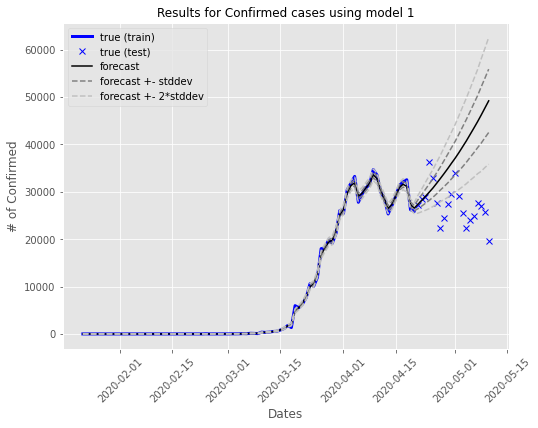

Results with Sigma 15.0, Tau 0.1 and Beta 1.0


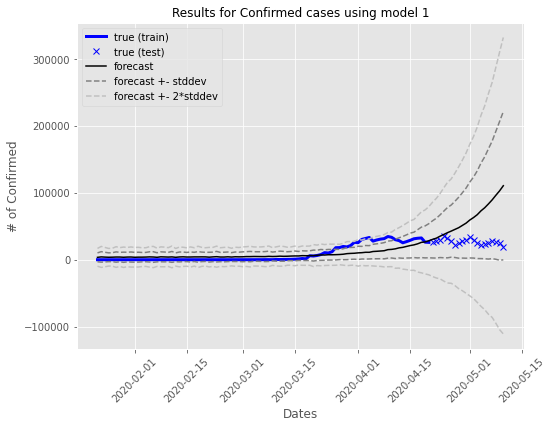

Results with Sigma 0.1, Tau 0.1 and Beta 10.0


Results with Sigma 15.0, Tau 0.1 and Beta 10.0


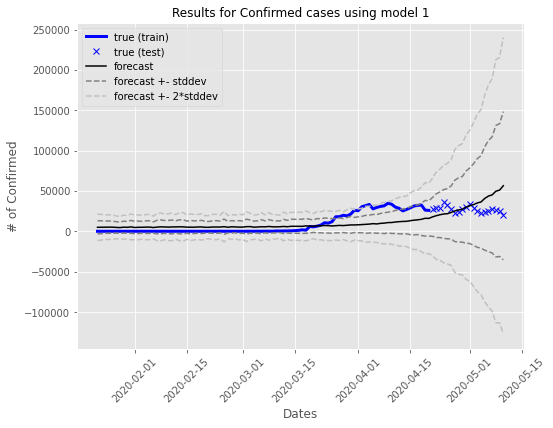

Results with Sigma 0.1, Tau 10.0 and Beta 1.0


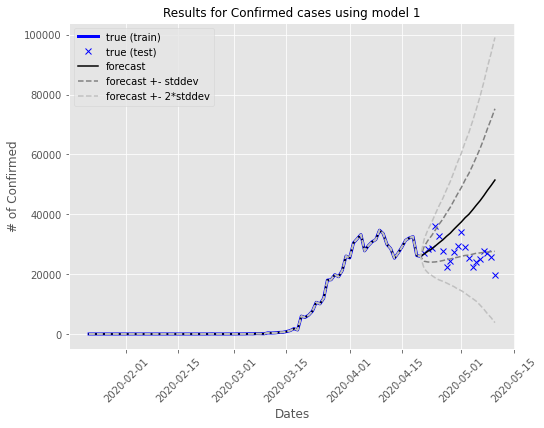

Results with Sigma 15.0, Tau 10.0 and Beta 1.0


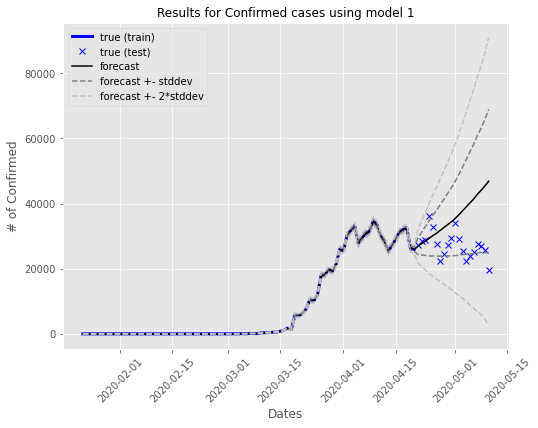

Results with Sigma 0.1, Tau 10.0 and Beta 10.0


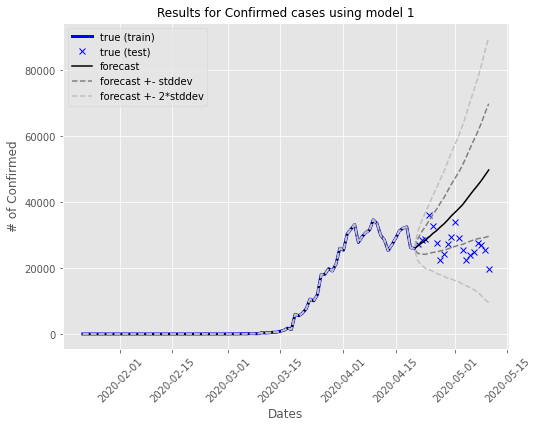

Results with Sigma 15.0, Tau 10.0 and Beta 10.0


In [0]:
plt.rcParams["figure.figsize"] = (8,6)
for i in range(len(beta_model_1)):
  print('Results with Sigma {0}, Tau {1} and Beta {2}'.format(sigma_model_1[i],
                                                              tau_model_1[i], 
                                                              beta_model_1[i] ))

  # get mean and standard devitions for predictions
  y_hat_model_1_temp = (samples_different_values_model_1[i]["y_hat"]**2).mean(axis=0)
  y_std_model_1_temp = (samples_different_values_model_1[i]["y_hat"]**2).std(axis=0)

  plot_results('Confirmed', y_hat_model_1_temp, y_std_model_1_temp,  1,[0])
  plt.show()

The shape of the predicted curve strongly resembles the prior predictive sampling. From this it can also be seen that the plots with high sigma values appears to have a very high standard deviation. As we are not interested in this we only test for small sigma values going forward. 

To get a quantitive measure of which hyper parameters fit the best, the root mean squared error is computed for the training data and the hyper paramters which results in the lowest values are selected: 


In [0]:
RMSE_model_1 = np.zeros(len(sigma_model_1))
#Calculate the RMSE for all the models
for i in range(len(beta_model_1)):
  y_hat_model_1_temp = (samples_different_values_model_1[i]["y_hat"]**2).mean(axis=0)[:T]
  RMSE_model_1[i] = mean_squared_error((y_train[:,0]), y_hat_model_1_temp, 
                                      squared = False)

#### Results for model 1

The minimum error is found: 

In [0]:
min_RMSE_model_1 = min(RMSE_model_1)
idx_min_model_1 = np.argmin(RMSE_model_1)

beta_min_model_1 = beta_model_1[idx_min_model_1]
tau_min_model_1 = tau_model_1[idx_min_model_1]
sigma_min_model_1 = sigma_model_1[idx_min_model_1]

print('The parameter values, that caused the lowest mean squared errors are:')
print('beta : ', beta_min_model_1)
print('tau : ', tau_min_model_1)
print('sigma : ', sigma_min_model_1)

The parameter values, that caused the lowest mean squared errors are:
beta :  1.0
tau :  10.0
sigma :  0.1


The predictions with the optimal hyper parameters are plotted: 


The Root Mean Squared Error for Model 1 is 14428.94


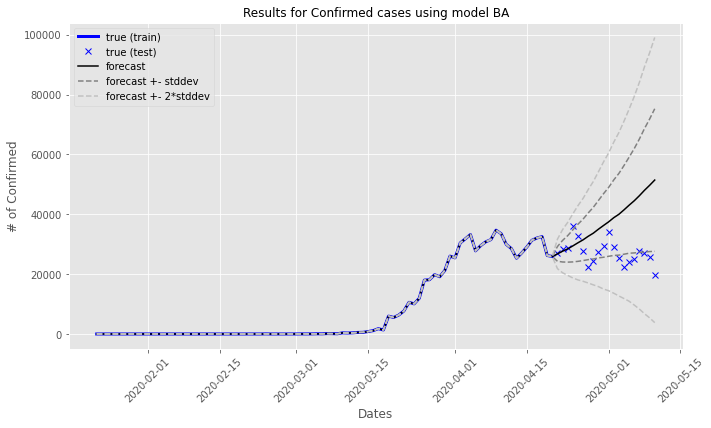

In [0]:
y_hat_model_1_min = (samples_different_values_model_1[idx_min_model_1]["y_hat"]**2).mean(axis=0)
y_std_model_1_min = (samples_different_values_model_1[idx_min_model_1]["y_hat"]**2).std(axis=0)

# the predictions are transformed back 
# get mean and standard devitions for predictions 
y_hat_model_1_test = (samples_different_values_model_1[idx_min_model_1]["y_hat"]**2).mean(axis=0)[T:]
RMSE_model_1_C = mean_squared_error((y_test[:,0]), y_hat_model_1_test, squared = False)

print('The Root Mean Squared Error for Model 1 is {0}'.format(RMSE_model_1_C.round(2)))
plt.rcParams["figure.figsize"] = (11,6)
plot_results('Confirmed', y_hat_model_1_min, y_std_model_1_min,  'BA',[0])

Above the model with the hyper parameters that resulted in the lowest test error is plotted. From this it can be seen that all the data points lie within the 2 standard deviation. When using a normal distribution 98% of the data should lie within the 2nd standard deviation. From the plot it can be seen that 64% of the data does not lie within the first standard deviation. This indicates that further tuning of the hyper paramters or a more complicated model might be needed. 


In [0]:
# prepare data for Stan model
data_model_1 = {'T': T, 'T_forecast': T_forecast, 'y': y_C, 
                'tau_val':tau_min_model_1,'sigma_val':sigma_min_model_1, 
                'beta_val':beta_min_model_1}

We run the model with the prepared data: 

In [0]:
samples_model_1_final, fit_model_1_final = fit_the_model(data_model_1, model_1_definition)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_fa970e16e5bcfae3d32e8596eb9434e9 NOW.


Now that the optimal model has been found we look at the fit and the priors: 

In [0]:
print(fit_model_1_final)

Inference for Stan model: anon_model_fa970e16e5bcfae3d32e8596eb9434e9.
4 chains, each with iter=500; warmup=250; thin=1; 
post-warmup draws per chain=250, total post-warmup draws=1000.

             mean se_mean     sd   2.5%     25%    50%    75%  97.5%  n_eff   Rhat
beta         1.01  4.8e-4 8.6e-3    1.0    1.01   1.01   1.02   1.03    322   1.01
tau          7.29    0.02   0.55   6.23    6.89   7.27   7.64    8.5    501    1.0
sigma        0.08    0.02   0.06   0.02    0.04   0.07   0.11   0.24     11   1.43
z[1]          1.0  2.8e-3    0.1    0.8    0.96    1.0   1.05   1.22   1199    1.0
z[2]         0.07    0.01   0.07 2.1e-3    0.02   0.04    0.1   0.28     28   1.12
z[3]          1.0  3.8e-3    0.1   0.76    0.96    1.0   1.04   1.24    718    1.0
z[4]         0.07    0.01   0.08 1.1e-3    0.02   0.04   0.08    0.3     44    1.1
z[5]         1.74  2.6e-3    0.1   1.51    1.69   1.73   1.78   1.96   1581    1.0
z[6]         0.07    0.01   0.08 2.3e-3    0.02   0.05   0.09   0.2

In [0]:
plt.rcParams["figure.figsize"] = (13,17)
fit_model_1_final.plot(["beta","tau","sigma","lp__"])
plt.show()

Above the distributions that resulted in the lowest error have been plotted. This to appears randomly sampled, except for the sigma value, which again indicates that further tuning is needed or that the model might be too simple. 

#### Conclusion for Model 1
Overall the model seems like a relatively good fit for the data which lies within the second standard deviation but is not able capture steady state structure. The test error will be compared to that of the other models to get a measure of which model describes the data the best. 
The high error could be interpreted as the model is a bit too simple for the data. 
Furthermore it can be seen the data appears to have different stages; First it is pretty constant, then it has what appears to be exponential growth and lastly it appears to flatten out again. In the next section we will try to examine this furher. 

### 3.3 Model 2 - Manual change points model  (BAC)

The findings in previous section indicates that the model should consist of a change point. Thus, a *Manual change point model* will be implemented in this section. The figure in *section 2.3 Visualization* illustrate that the Confirmed cases have a "slow" start, after which it almost increases exponentially. Additionally, at a point the Confirmed cases begins to enter a steady state periode or a decreasing period. 

The first chosen change point is the 2020-03-12, which is 50 days after the first documented confirmed case in the US. This date is chosen as the Confirmed cases begin to increase at that point
 (https://www.bloomberg.com/graphics/2020-united-states-coronavirus-outbreak/).
 

The second chosen change point is the 2020-04-01, which is 70 days after the first documented confirmed case in the US. The curve seemes to either reach a steady period or a decreasing period. 

#### Basic Autoregressive model with change points

The model is implemeted in STAN, where the chosen distributaions are normal. The model resembles Model 1, as it is based on a hidden markov model that predicts the next value using the previous timepoint. The difference between Model 1 and Model 2 are the two change points at timestep 50 and 70. There are three state transition coefficients, state transistion noises and observation noises which correspond to the period before, between and after the two change points. 

In [0]:
model_2_definition = """
data {
 int<lower=1> T;            // length of the time-series
 int<lower=0> T_forecast;   // num. steps ahead to predict
 real<lower=0> y[T];        // time-series data
 real<lower=0> beta_val;    // Prior on beta
 real<lower=0> tau_val;     // Prior on tau
 real<lower=0> sigma_val;   // Prior on sigma
 real<lower=0> c_p_1;       // First change point 
 real<lower=0> c_p_2;       // Second change point

}
 
parameters {
 real beta[3];                  // state transition coefficients
 real<lower=0> tau[3];          // state transition noise
 real<lower=0> sigma;           // observation noise
 real<lower=0> z[T+T_forecast]; // vector of latent states
}
 
model {
 for(i in 1:3){
    beta[i] ~ normal(0,beta_val);  // prior on the auto-regressive coefficients
    tau[i] ~ normal(0,tau_val);    // prior on the variance
 }
 sigma ~ normal(0,sigma_val);      // prior on the variance
 
 z[1] ~ normal(0, 10);            //  fat prior on first state
 
 for(t in 2:(T+T_forecast)) {
    if (t <=c_p_1){
        z[t] ~ normal(beta[1] * z[t-1] , tau[1]);   // latent dynamics
    }
    else if (t > c_p_1 && t<= c_p_2) {
        z[t] ~ normal(beta[2] * z[t-1] , tau[2]);   // latent dynamics
    }
    else {
         z[t] ~ normal(beta[3] * z[t-1] , tau[3]);  // latent dynamics
    }
 }
 
 y[1:T] ~ normal(z[1:T], sigma);                    // likelihood
 
}
 
generated quantities {
 
 vector[T+T_forecast] y_hat;              // vector to store predictions
 
 for (t in (1):(T+T_forecast)) {
    y_hat[t] <- normal_rng(z[t], sigma); // prediction
  }
}
"""

The chosen values have been found through a sensistivity analysis, where they gave the lowest RMSE score for the traning data. However, the analysis is not included in this Notebook, since a simplification is wanted. 
The data for Model 2 is prepared below. 

In [0]:
# prepare data for Stan model
c_p_1_model_2 = 50
c_p_2_model_2 = 70
data_model_2 = {'T': T, 'T_forecast': T_forecast, 'y': y_C,
                'beta_val': 1, 'tau_val':2, 'sigma_val': 2, 
                'c_p_1':c_p_1_model_2, 'c_p_2': c_p_2_model_2} 


The STAN code is now compiled and run.

In [0]:
samples_model_2, fit_model_2 = fit_the_model(data_model_2, model_2_definition)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_d3ea31873d6ad8c4fa4ebc701eb57c09 NOW.


#### Results for Model 2

The result from Model 2 are showned in below table to examine them. 

In [0]:
print(fit_model_2)

Inference for Stan model: anon_model_d3ea31873d6ad8c4fa4ebc701eb57c09.
4 chains, each with iter=500; warmup=250; thin=1; 
post-warmup draws per chain=250, total post-warmup draws=1000.

             mean se_mean     sd    2.5%    25%    50%    75%  97.5%  n_eff   Rhat
beta[1]      1.17  1.4e-3   0.02    1.14   1.16   1.17   1.18    1.2    130   1.02
beta[2]      1.07  8.3e-4   0.02    1.03   1.06   1.07   1.08   1.11    679    1.0
beta[3]       1.0  8.3e-4 9.4e-3    0.98   0.99    1.0    1.0   1.02    130   1.03
tau[1]       0.16    0.01   0.09    0.05   0.09   0.14   0.22    0.4     47   1.09
tau[2]       7.96    0.03   0.82    6.53   7.38   7.97   8.47   9.68    874    1.0
tau[3]       6.52    0.04   0.82    5.19   5.93   6.43   7.01   8.36    412   1.01
sigma        1.45  7.8e-3   0.16    1.18   1.34   1.43   1.55   1.81    437    1.0
z[1]         0.28    0.02   0.26    0.01   0.11   0.21   0.37   0.96    133   1.03
z[2]         0.31    0.03   0.26    0.03   0.13   0.23   0.41   0.9

Here are the state transition coefficients escpecially interesting since they say something about the Confirmed cases development. 


*   The mean of state transition coefficient before the first change point is: 1.18 
*   The mean of state transition coefficient bewteen the two change points is: 1.07
*   The mean of state transition coefficient bewteen the two change points is: 1.0

This result indicates that the Confirmed cases are increasing both before and after the first change point. However, the state transition coefficient bewteen the two change points is smaller, hence, the Confirmed cases are not increasing by as much. Furthermore, the state transition coefficient after the second change point is 1, which indicates that number of confirmed cases are neither increasing or decreasing. 

Additionally, the state transition noise between the two change points and after the second change point are also interesting since the mean value are respectively, 8.56 and 6.92. Meaning the state transitions have the opptunity to fluctuate a lot.    

Next, the parameters from Model 2 are plotted below to see that it looks as expected.

In [0]:
plt.rcParams["figure.figsize"] = (13,17)
fit_model_2.plot(["beta","tau","sigma","lp__"])
plt.show()

The above figure illustrate that the variables are all relatively randomly sampled. The figure also shows that the model is relatively sure on must of the parameteres.

The prediction from Model 2 is now illustated. The data is first transformed back to normal and the mean and standard deviation are found. 

In [0]:
# the predictions are transformed back 
# get mean and standard devitions for predictions 
y_hat_model_2 = (samples_model_2["y_hat"]**2).mean(axis=0)
y_std_model_2 = (samples_model_2["y_hat"]**2).std(axis=0)


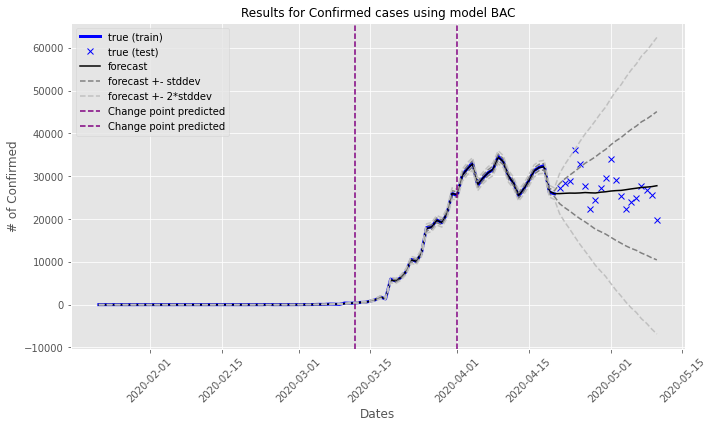

In [0]:
plt.rcParams["figure.figsize"] = (11,6)
plot_results('Confirmed', y_hat_model_2, y_std_model_2,  'BAC'
             ,[c_p_1_model_2,c_p_2_model_2])

The figure illustate that the esitmated cases are reaching a steady periode, which is supported by the state transition coefficient, which was 1 for this period. 
The standard deviation curves illustrate, that it becomes more and more unsure (benefit from baysian sampling). Additionally, for a gaussian distribution, approximately 64% of the points should be within one standard deviation, which is 
achieved in this model. Around 98% of the point should be within two standard deviation, which in this case means all points should be inside and this is also fulfilled. 


##### RMSE for model 2
The RMSE score for the test data is calculated for Model 2 to better comparison between Model 1 and Model 2. 

In [0]:
# the predictions are transformed back 
# get mean and standard devitions for predictions 
y_hat_model_2_test = (samples_model_2["y_hat"]**2).mean(axis=0)[T:]

In [0]:
 RMSE_model_2 = mean_squared_error((y_test[:,0]), y_hat_model_2_test, squared = False)
 print('The Mean Squared Error result for Model 2 is {0}'.format(RMSE_model_2.round(2)))

The Mean Squared Error result for Model 2 is 4244.84


Model 2 does perform better that the initial Model 1, which RMSE score on the test data was 14428.94. Which indicates, that the data does consist of a change point. 


#### Conclusion for Model 2

The Manual change points model performed relatively well, as it performed better than model 1. Additionally, the model was able to 
achieve the number of data point which should be within the first and second standard deviation. 

### 3.4 Model 3 - Vector Autoregressive Model (VA)

The information that was obtained from Model 2 regarding the change point, will in this Model 3 be set aside. Model 3 will instead investigate whether the Confirmed, Deaths and Recovered cases 
are connected with the help of a Vector Autoregression Model. 

The Vector Autoregression Model captures the linear interdependencies among multiple time series. The model is based on the the univariate autoregressive model but is allowed for more than one time series.

#### Vector Autoregressive model

As the two previous models (Model 1 and Model 2) all the parameteres are drawn from a normal distributaion. First, the model is implemeted in STAN. 

The model does also resembles Model 1, as it is based on a hidden markov model that predicts the next value using the previous timepoint. Model 2 differ by including all the time series, namely Confirmed, Deaths and Recovered case.

In [0]:
# define Stan model
model_3_definition = """
data {
    int<lower=1> T;             // length of the time-series
    int<lower=0> T_forecast;    // num. steps ahead to predict
    real y1[T];                 // time-series data
    real y2[T];                 // time-series data
    real y3[T];                 // time-series data
    real<lower=0> beta_val ;    // Prior on beta
    real<lower=0> tau_val ;     // Prior on tau
    real<lower=0> sigma_val ;   // Prior on sigma

}

parameters {
    real beta1[3];                     // first state transition coefficients
    real beta2[3];                     // second state transition coefficients
    real beta3[3];                     // third state transition coefficients
    real<lower=0> tau[3];              // state transition noise
    real<lower=0> sigma[3];            // observation noise
    real<lower=0> z1[T+T_forecast];    // vector of latent states
    real<lower=0> z2[T+T_forecast];    // vector of latent states
    real<lower=0> z3[T+T_forecast];    // vector of latent states
}

model {
    for(i in 1:3){
        beta1[i] ~ normal(0,beta_val);  //  prior on the auto-regressive coefficients
        beta2[i] ~ normal(0,beta_val);  //  prior on the auto-regressive coefficients
        beta3[i] ~ normal(0,beta_val);  //  prior on the auto-regressive coefficients
        tau[i] ~ normal(0,tau_val);     // prior on the variance
        sigma[i] ~ normal(0,sigma_val); // prior on the variance
    }
    
    z1[1] ~ normal(0, 10);           //  fat prior on first state for first latent state 
    z2[1] ~ normal(0, 10);           //  fat prior on first state for second latent state 
    z3[1] ~ normal(0, 10);           //  fat prior on first state for third latent state 

    for(t in 2:(T+T_forecast)) {
        z1[t] ~ normal(beta1[1] * z1[t-1] + beta1[2] * z2[t-1] + beta1[3] * z3[t-1], tau[1]); // first latent dynamics
        z2[t] ~ normal(beta2[1] * z1[t-1] + beta2[2] * z2[t-1] + beta2[3] * z3[t-1], tau[2]); // second latent dynamics
        z3[t] ~ normal(beta3[1] * z1[t-1] + beta3[2] * z2[t-1] + beta3[3] * z3[t-1], tau[3]); // third latent dynamics
    }
    
    y1[1:T] ~ normal(z1[1:T], sigma[1]);    // likelihood
    y2[1:T] ~ normal(z2[1:T], sigma[2]);    // likelihood
    y3[1:T] ~ normal(z3[1:T], sigma[3]);    // likelihood
}

generated quantities {
    vector[T + T_forecast] y_hat1;          // vector to store predictions
    vector[T + T_forecast] y_hat2;          // vector to store predictions
    vector[T + T_forecast] y_hat3;          // vector to store predictions
    
    for (t in (1):(T+T_forecast)) {
        y_hat1[t] <- normal_rng(z1[t], sigma[1]);  // predictions
        y_hat2[t] <- normal_rng(z2[t], sigma[2]);  // predictions
        y_hat3[t] <- normal_rng(z3[t], sigma[3]);  // predictions
    }
}
"""

The chosen values have again been found through a sensistivity analysis, where they gave the lowest RMSE score for the traning data. However, the analysis is not included in this Notebook, since a simplification is wanted. 
The data for Model 3 is prepared below. 

In [0]:
# prepare data for Stan model
data_model_3 = {'T': T, 'T_forecast': T_forecast,
                'y1': y_C,'y2': y_D, 'y3': y_R,
                'beta_val': 0.5, 'tau_val':5, 'sigma_val':0.1 }


The STAN code is now compiled and run.

In [0]:
samples_model_3, fit_model_3 = fit_the_model(data_model_3, model_3_definition)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_3d44cda4086b45b2292b8e625cc0a49e NOW.


#### Results for Model 3

The result from Model 3 are showned in below table and figure.

In [0]:
print(fit_model_3)

Inference for Stan model: anon_model_3d44cda4086b45b2292b8e625cc0a49e.
4 chains, each with iter=500; warmup=250; thin=1; 
post-warmup draws per chain=250, total post-warmup draws=1000.

              mean se_mean     sd   2.5%     25%     50%    75%  97.5%  n_eff   Rhat
beta1[1]       1.1  2.1e-3   0.04   1.02    1.07     1.1   1.12   1.18    394   1.01
beta1[2]     -0.29    0.01   0.22  -0.71   -0.43   -0.29  -0.14   0.12    416    1.0
beta1[3]     -0.07  2.7e-3   0.08  -0.21   -0.12   -0.06  -0.02   0.08    799    1.0
beta2[1]      0.08  6.4e-4   0.01   0.05    0.07    0.08   0.09   0.11    504    1.0
beta2[2]      0.58  4.0e-3   0.08   0.42    0.53    0.58   0.63   0.74    392   1.01
beta2[3]      0.07  1.1e-3   0.03   0.02    0.06    0.08   0.09   0.13    538    1.0
beta3[1]    2.4e-4  2.4e-3   0.05  -0.09   -0.03 -1.1e-3   0.03    0.1    426    1.0
beta3[2]       0.9    0.01   0.25   0.37    0.73    0.91   1.08   1.38    376    1.0
beta3[3]      0.29  3.3e-3   0.09    0.1    0.23 

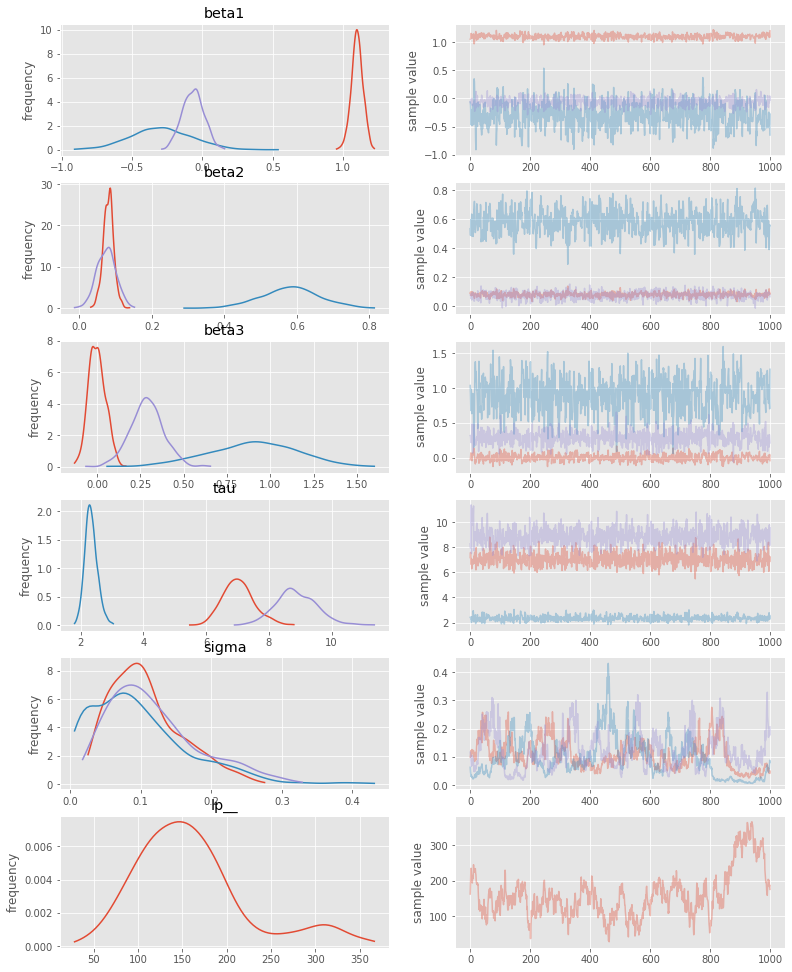

In [0]:
plt.rcParams["figure.figsize"] = (13,17)
fit_model_3.plot(["beta1","beta2","beta3","tau","sigma","lp__"])
plt.show()

The above figure illustrate that the variables are all relatively randomly sampled. However, the sigma values are fluctuating a bit compared to the other values. 


Next, the predictions for Confirmed, Deaths and Recovered from Model 3 are illustated. The data for each case are first transformed back to normal and the mean and standard deviation are then found.

In [0]:
# get mean and standard devitions for predictions
y_hatC_model_3 = (samples_model_3["y_hat1"]**2).mean(axis=0)
y_stdC_model_3 = (samples_model_3["y_hat1"]**2).std(axis=0)
y_hatD_model_3 = (samples_model_3["y_hat2"]**2).mean(axis=0)
y_stdD_model_3 = (samples_model_3["y_hat2"]**2).std(axis=0)
y_hatR_model_3 = (samples_model_3["y_hat3"]**2).mean(axis=0)
y_stdR_model_3 = (samples_model_3["y_hat3"]**2).std(axis=0)

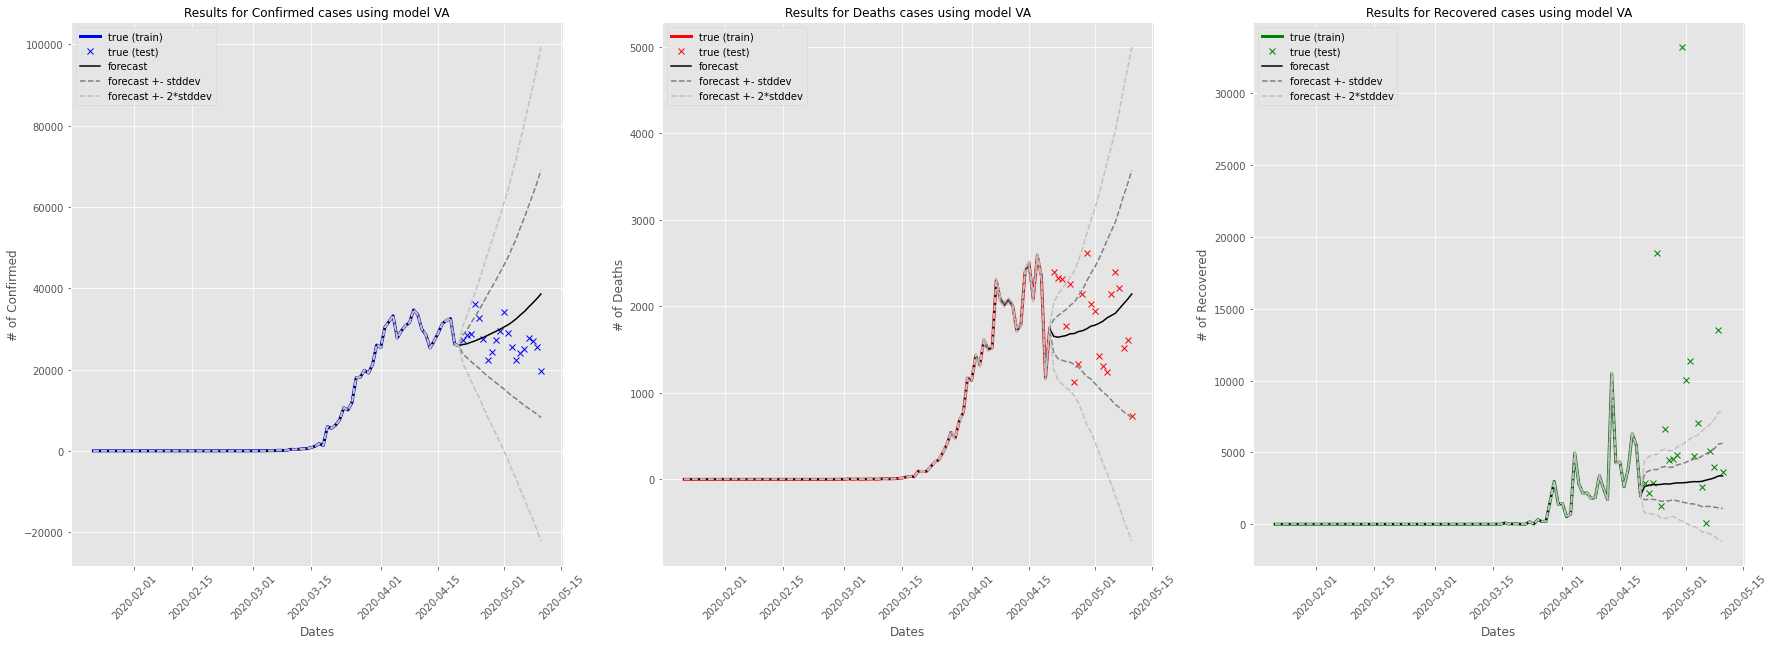

In [0]:
plt.rcParams["figure.figsize"] = (30,10)
plt.subplot(1,3, 1)  
plot_results('Confirmed', y_hatC_model_3, y_stdC_model_3,  'VA',[0])
plt.subplot(1,3, 2)
plot_results('Deaths', y_hatD_model_3, y_stdD_model_3,  'VA',[0])
plt.subplot(1,3, 3)
plot_results('Recovered', y_hatR_model_3, y_stdR_model_3,  'VA',[0])


The above figure for Confirmed and death cases illustates that the esitmated cases continue to increase. It can also be seen that the standard deviation curve illustrates, that the model becomes more and more unsure. This is not favorable for the confirmed cases, since model 2 showed, that the data should reach a more steady period. However, the model is able to have all data points for Confirmed cases within two standard deviation, which suggest, the model capture the data better than model 1.  
The Death cases figure illustrate that the model does not achive all data points within two standard deviation, however more than 64% of the data point is within one standrd deviation. 

The model does however not perform well on the Recovered cases, it is not able to caputre the high spikes, which is in the data. The figure illustrate that the model is not able to capture 98% or 64% for respectively two and one standard diviation. 




##### RMSE for model 3
The RMSE score for the test data is calculated for Model 3 to better compare it with Model 1 and Model 2.

The score is calculated for Confirmed, Deaths and Recovered. Model 1 and Model 2 are only for the Confirmed data, thus, it is only Confirmed score for Model 3 that can be compared. 

In [0]:
# the predictions are transformed back 
# get mean and standard devitions for predictions
y_hatC_model_3_test = (samples_model_3["y_hat1"]**2).mean(axis=0)[T:]
y_hatD_model_3_test = (samples_model_3["y_hat2"]**2).mean(axis=0)[T:]
y_hatR_model_3_test = (samples_model_3["y_hat3"]**2).mean(axis=0)[T:]

In [0]:
RMSE_model_3_C = mean_squared_error((y_test[:,0]), y_hatC_model_3_test, squared = False)
print('The Root Mean Squared Error result for Confirmed in Model 3 is {0}'.format(RMSE_model_3_C.round(2)))

The Root Mean Squared Error result for Confirmed in Model 3 is 7616.17


In [0]:
RMSE_model_3_D = mean_squared_error((y_test[:,1]), y_hatD_model_3_test, squared = False)
print('The Root Mean Squared Error result for Deaths in Model 3 is {0}'.format(RMSE_model_3_D.round(2)))

The Root Mean Squared Error result for Deaths in Model 3 is 587.31


In [0]:
RMSE_model_3_R = mean_squared_error((y_test[:,2]), y_hatR_model_3_test, squared = False)
print('The Root Mean Squared Error result for Recovered in Model 3 is {0}'.format(RMSE_model_3_R.round(2)))

The Root Mean Squared Error result for Recovered in Model 3 is 8563.56


It can be seen, that the model does perform better than the initial model 1 in the confirmed cases. However it perform slightly worse than Model 2.


#### Conclusion for Model 3

The model did not perform better than model 2 in regards to the RMSE score on test data  for the confirmed cases but it did perform better than model 1. This indicates that maybe a compination of model 2 and 3 will result in a a better model, which is able to capture the change pont and the linear dependencies between the Confirmed, Deaths and recovered cases. 

Model 3 did perform relatively good in regards to capturing the data for the confirmed and deaths cases. However, as the figure illustrates, the model was not able to capture the fluctuating structure of the recovered cases. Hence, the model might benefit to change from normal distribution to a student t distribution, as this allows for a bigger tail in the distribution. 


### 3.5 Model 4 - Change point & vector autoregression model (VAC)

A correlation for the three variables confirmed, deaths and recovered was found in the data description section, and because vector autoregression allows for a connection between variables, this will be the final model for the analysis with an including change point for each variable. Thus, this final model is a combination of all previous models which now includes all three variables and in addition also a method to predict the change point. The change point method is implemented using the probabilistic language STAN in a similar way as the models.

\\





\\
The final model can be represented as the probabilistic graphical model seen here:

<img src="https://drive.google.com/uc?id=1-Kdl0cPkEJnHdwjqXbz49INl_nM2P71W" width="500"/>

\\
The parameter $c_{i}$, i is 1 (Confirmed), 2 (Deaths) or 3 (Recovered) and corresponds to each slope i.e. starting value for each variable. The term $\sigma$ describes the noise for each equation and is drawn from a normal distribution and $\beta_{i,j}$ is the transition coefficient where $ i \in \{1,2,3\}$ and  $j \in \{1,2,3\}= \{Confirmed,Deaths,Recovered\}. $

\
As shown previously, it was difficult to fit the model when all of the data was used as input. It therefore seemed more appropriate to implement a changing point which allows the parameters to change. This changing point will be predicted for all three variables and used in the final model. Therefore, this section is divided into a changing point predicion and a model using this timepoint  for a cause of shift. 

\

The generative process is as following:

\
<img src="https://drive.google.com/uc?id=1gc51EeD3NcTsmFXTM5zYjPxYg1wNoX3b" width="500"/>


#### 3.5.1 Changing point prediction for confirmed, deaths and recovered

The change point predictor model is inspired by Fonnesbeck et al. (2013, Section 3.1) (1), which produced a Poisson model to describe a disaster $D_{t}$ at time t, where an early (e) occurs before the change point s, and a differente rate - a late rate (l) occurs after. 
<br />
<br />
$e \sim\ exponential(r_{e})$

$l \sim\ exponential(r_{l})$

$s \sim\ uniform(1,T)$

$D_{t} \sim\ Poisson(t < s ? e : l)$
<br />
<br />
The early and late rate is drawn from an exponential distribution and the change point s from a uniform distribution. If s is true, then it appears to be an early rate and if false then it is a late state. The STAN code can be seen below where the actual extraction of the change point s has been implemented in the generated quantiles block. 

It was also demonstrated by Adams and MacKay on three real-world data sets that calculated the posterior probability by an exact method (https://arxiv.org/abs/0710.3742. 

In our study, some interesting aspects are if it is actually able to find a change point, and if that change point in fact can be related to political interference to limit the spread of corona virus or other influencing factors. 

(1) Fonnesbeck, Chris, Anand Patil, David Huard, and John Salvatier. 2013. PyMC User’s Guide. Assesed from https://mc-stan.org/docs/2_23/stan-users-guide/change-point-section.html#ref-PyMC:2014 

In [0]:
# define Stan model
change_point_predictor = """
data {

  // Constrains for lambda function

  real<lower=0> r_e;
  real<lower=0> r_l;

  // Constrains for T and creation of vector D, 
  // corresponding to the data which is of length T

  int<lower=1> T;
  int<lower=0> D[T];
}
transformed data {
  real log_unif;
  log_unif = -log(T);
}
parameters {
  real<lower=0> e;
  real<lower=0> l;
}
transformed parameters {

    // The posterior probability is calculated

    vector[T] lp;
    {
      vector[T + 1] lp_e;
      vector[T + 1] lp_l;
      lp_e[1] = 0;
      lp_l[1] = 0;
      for (t in 1:T) {
        lp_e[t + 1] = lp_e[t] + poisson_lpmf(D[t] | e);
        lp_l[t + 1] = lp_l[t] + poisson_lpmf(D[t] | l);
      }
      lp = rep_vector(log_unif + lp_l[T + 1], T)
           + head(lp_e, T) - head(lp_l, T);
    }
  }
model {
   
  // Log sum allows the model to be coded directly in STAN. 

  e ~ exponential(r_e);
  l ~ exponential(r_l);
  target += log_sum_exp(lp);
}
generated quantities {

  // Extract the change point in "s"

  int<lower=1,upper=T> s;
  s = categorical_logit_rng(lp);
}
"""

The squared data is not used as input in this model, as the change point predictor model only takes integers as input and squared data is not in an integer format. The inputs ($\lambda$) for the exponential distribution are set to the value 2, which gives is a steeper graph at lower values, compared to $\lambda$ values below 2 and was found to work well in this case, but further study might reveal more suitable input values.

In [0]:
data_change_point_predictor_C = {'r_e': 2, 'r_l':2,'T': T,'D': y_train[:,0]}
data_change_point_predictor_D = {'r_e': 2, 'r_l':2,'T': T,'D': y_train[:,1]}
data_change_point_predictor_R = {'r_e': 2, 'r_l':2,'T': T,'D': y_train[:,2]}

In [0]:
samples_cp_C, fit_model_cp_C = fit_the_model(data_change_point_predictor_C, 
                                             change_point_predictor)

samples_cp_D, fit_model_cp_D = fit_the_model(data_change_point_predictor_D, 
                                             change_point_predictor)

samples_cp_R, fit_model_cp_R = fit_the_model(data_change_point_predictor_R, 
                                             change_point_predictor)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_4c21492a77b57890bcf5b7bf0d9d9c5e NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_4c21492a77b57890bcf5b7bf0d9d9c5e NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_4c21492a77b57890bcf5b7bf0d9d9c5e NOW.


In [0]:
s_C = samples_cp_C['s'].mean().astype(int)
s_C_date = data['Date'].iloc[s_C]
print('The change point for Confirmed is {0} which correspond to date {1} '.format(s_C,s_C_date ))

s_D = samples_cp_D['s'].mean().astype(int)
s_D_date = data['Date'].iloc[s_D]
print('The change point for Deaths is {0} which correspond to date {1} '.format(s_D,s_D_date ))

s_R = samples_cp_R['s'].mean().astype(int)
s_R_date = data['Date'].iloc[s_R]
print('The change point for Recovered is {0} which correspond to date {1} '.format(s_R,s_R_date ))


The change point for Confirmed is 58 which correspond to date 2020-03-20 00:00:00 
The change point for Deaths is 65 which correspond to date 2020-03-27 00:00:00 
The change point for Recovered is 79 which correspond to date 2020-04-10 00:00:00 


Only one change point per variable was found here even though we expected that there might have been two change points, as could be seen in the earlier model for maunal change point. In order to investigate the reason for this, the code was executed for Norway, which is not shown here but can be changed in the data preparation part if one is interested in running this analysis for other countries as well. As Norway had a decrease at the end of the time period, it actually found two changing point. This means, that for the Unites States of America it is not decreasing yet at the end of this timeperiod, and therefore it is not able to find more than one change point. Thus, an early rate appears to be before 2020-03-20 and after this a late rate is found. This also fits well with the data since an increasing can be found after this time point.

<br />

The 20th of March USA stated that confirmed cases continued to increase. They implemented travel restrictions and ordered New Yorkers to stay at home (https://www.bloomberg.com/graphics/2020-united-states-coronavirus-outbreak/). 

At the 27th of March, WHO Situation Report (1) stated that the confirmed cases were overtaking China (81,782) and Italy (80,589) by 101,242 cases and that the US death toll passed the number 1,500. 

The change point for recovered was found to be the 10th of April. Most articles and timelines focuses on the confirmed and deaths cases and report over 16,500 deaths (2). However, a reopening of some states occured this day (https://www.bbc.com/news/world-us-canada-52421730) and since there is an increase in confirmed cases it also make sense that there would be a corresponding increase in the recovered cases. 

<br />

(1) ("Situation Report 67". World Health Organization. Retrieved 27 March 2020)
(2) Regencia, Ted; Stepansky, Joseph; Varshalomidz, Tamila (11 April 2020). "Global coronavirus death toll exceeds 100,000: Live updates". Al Jazeera. Archived from the original on 11 April 2020. Retrieved 11 April 2020.

#### Prior predictive sampling for model 4

Before the actual model is executed, prior predictive sampling will be used to ensure patterns and structure are reasonable. As another change, opposed to the previous autoregression model. The t distribution is used instead of the normal distribution for the likelihood, since this might be able to capture more of the data (1) and the change points for the three variables are used as input in the model to tell the system to change. 


(1) (https://books.google.dk/books?id=cJSZDgAAQBAJ&pg=PA78&lpg=PA78&dq=%22t+distribution%22+for+modelling+disease+cases&source=bl&ots=T7Op8DZiTs&sig=ACfU3U3qve73nfbwuwUPBEssezz8RIzg2Q&hl=da&sa=X&ved=2ahUKEwjXtov_hdfpAhXHyKYKHbjLB2YQ6AEwAHoECAcQAQ#v=onepage&q=%22t%20distribution%22%20for%20modelling%20disease%20cases&f=false)

In [0]:
# define Stan model
model_4_sampling_definition = """
data {
  int<lower=1> T;          // length of the time-series
  int<lower=0> T_forecast; // num. steps ahead to predict
  real<lower=0> beta_val1; // Prior on beta1
  real<lower=0> beta_val2; // Prior on beta2
  real<lower=0> tau_val;   // Prior on tau
  real<lower=0> sig_val;   // Prior on sigma
  real<lower=0> s_C;       // Change point for confirmed cases 
  real<lower=0> s_D;       // Change point for death cases 
  real<lower=0> s_R;       // Change point for recovered cases 

}
 
parameters {
  real beta_state_1 [3,3];        // state transition coefficients
  real beta_state_2 [3,3];        // state transition coefficients
  real<lower=0> tau[3];           // state transition noise
  real<lower=0> sigma[3];         // observation noise
  real<lower=0> z1[T+T_forecast]; // vector of latent states
  real<lower=0> z2[T+T_forecast]; // vector of latent states
  real<lower=0> z3[T+T_forecast]; // vector of latent states
}
 
model {
  for(i in 1:3)
    for(j in 1:3)
      beta_state_1[i,j] ~ normal(0,beta_val1); 
  for(i in 1:3)
    for(j in 1:3)
      beta_state_2[i,j] ~ normal(0,beta_val2); 
  for(i in 1:3)
    tau[i] ~ normal(0,tau_val);   // prior on the variance 
  for(i in 1:3)
    sigma[i] ~ normal(0,sig_val); // prior on the variance
 

  z1[1] ~ normal(0, 10); // fat prior on first state
  z2[1] ~ normal(0, 10); // fat prior on first state
  z3[1] ~ normal(0, 10); // fat prior on first state
 
  for(t in 2:(T+T_forecast)) {

    // State 1
    if (t <=s_C){
      z1[t] ~ normal(beta_state_1[1,1] * z1[t-1] + beta_state_1[1,2] * z2[t-1] + beta_state_1[1,3] * z3[t-1], tau[1]); // latent dynamics
    }
    // State 2
    else {
      z1[t] ~ normal(beta_state_2[1,1] * z1[t-1] + beta_state_2[1,2] * z2[t-1] + beta_state_2[1,3] * z3[t-1], tau[1]); // latent dynamics
    }

    // State 1
    if (t <=s_D){
      z2[t] ~ normal(beta_state_1[2,1] * z1[t-1] + beta_state_1[2,2] * z2[t-1] + beta_state_1[2,3] * z3[t-1], tau[2]); // latent dynamics
    }
    // State 2
    else{
      z2[t] ~ normal(beta_state_2[2,1] * z1[t-1] + beta_state_2[2,2] * z2[t-1] + beta_state_2[2,3] * z3[t-1], tau[2]); // latent dynamics
    }

    // State 1
    if (t <=s_R){
      z3[t] ~ normal(beta_state_1[3,1] * z1[t-1] + beta_state_1[3,2] * z2[t-1] + beta_state_1[3,3] * z3[t-1], tau[3]); // latent dynamics
    }
    // State 2
    else {
      z3[t] ~ normal(beta_state_2[3,1] * z1[t-1] + beta_state_2[3,2] * z2[t-1] + beta_state_2[3,3] * z3[t-1], tau[3]); // latent dynamics
    }
  }
 

}
 
generated quantities {
  vector[T+T_forecast] y_hat1; // vector to store predictions
  vector[T+T_forecast] y_hat2; // vector to store predictions
  vector[T+T_forecast] y_hat3; // vector to store predictions
 
 for (t in 1:(T+T_forecast)) {
    y_hat1[t] <- student_t_rng(T+T_forecast -1, z1[t], sigma[1]); // predictions
    y_hat2[t] <- student_t_rng(T+T_forecast -1, z2[t], sigma[2]); // predictions
    y_hat3[t] <- student_t_rng(T+T_forecast -1, z3[t], sigma[3]); // predictions
 }
}
"""

The input values were chosen as can be seen from a trial-error just to get an indication of the model behavior. Low values (between 0.1-1) seemed to work decently compared to higher values. Later, a parameter tuning will be used to further optimise the model. 

In [0]:
  input_sampling_4 = {'T': T, 'T_forecast': T_forecast,
              'beta_val1': 1, 
              'beta_val2': 1, 
              'tau_val': 1, 'sig_val': 0.1, 
              's_C': s_C, 's_D':s_D, 's_R':s_R}

  samples_prior_predictive_4, fit_prior_predictive_4 = fit_the_model(input_sampling_4, 
                                             model_4_sampling_definition)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_e2f1e06cc02f0caf2cbc353d1979a35f NOW.


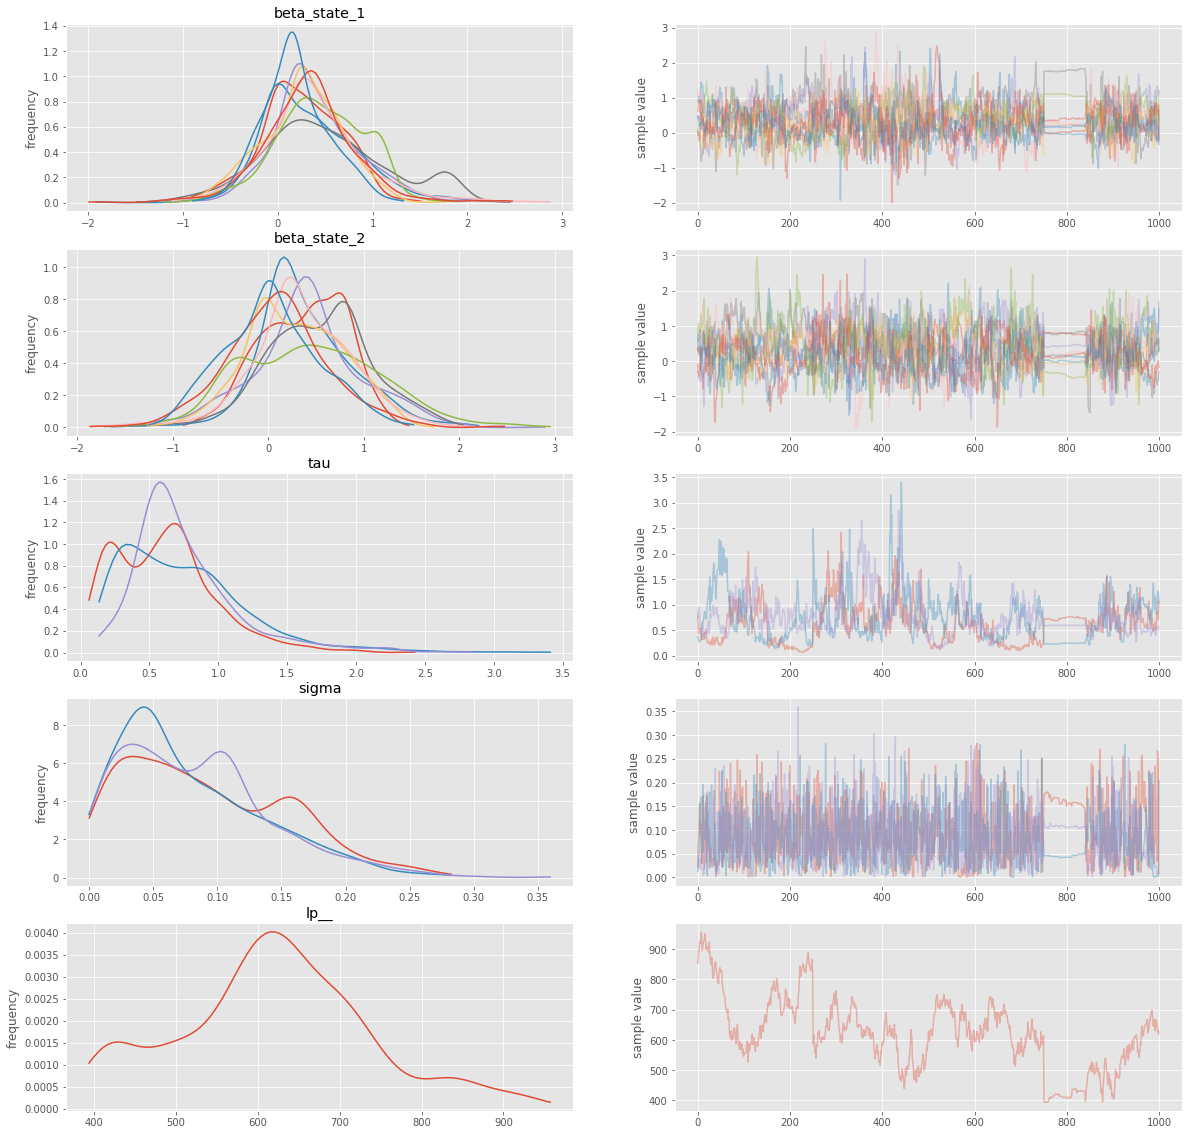

In [0]:
plt.rcParams["figure.figsize"] = (20,20)
fit_prior_predictive_4.plot(  ["beta_state_1","beta_state_2", "tau","sigma","lp__"])

plt.show()

The sampling looks more or less randomly scattered, except for a smaller period, where it looks more constrained and is varying less. This might be improved for a better collection of parameter input values.

In [0]:
# get mean and standard devitions for predictions
y_hat1_prior_predictive_4 = (samples_prior_predictive_4["y_hat1"]**2).mean(axis=0)
y_std1_prior_predictive_4 = (samples_prior_predictive_4["y_hat1"]**2).std(axis=0)
y_hat2_prior_predictive_4 = (samples_prior_predictive_4["y_hat2"]**2).mean(axis=0)
y_std2_prior_predictive_4 = (samples_prior_predictive_4["y_hat2"]**2).std(axis=0)
y_hat3_prior_predictive_4 = (samples_prior_predictive_4["y_hat3"]**2).mean(axis=0)
y_std3_prior_predictive_4 = (samples_prior_predictive_4["y_hat3"]**2).std(axis=0)

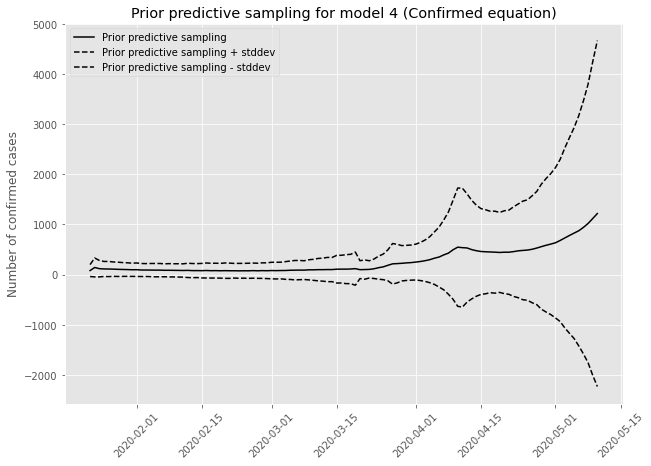

In [0]:
plt.figure(figsize=(10,7))
plt.plot(data[['Date']], y_hat1_prior_predictive_4, color = color_estimated, linestyle="-", linewidth = 1.5)
plt.plot(data[['Date']], y_hat1_prior_predictive_4 + y_std1_prior_predictive_4, color = color_estimated, linestyle="--",linewidth = 1.5)
plt.plot(data[['Date']], y_hat1_prior_predictive_4 - y_std1_prior_predictive_4,color = color_estimated , linestyle= "--",linewidth = 1.5)
plt.xticks(rotation=45)
plt.ylabel('Number of confirmed cases')
plt.legend(["Prior predictive sampling","Prior predictive sampling + stddev","Prior predictive sampling - stddev"])
plt.title('Prior predictive sampling for model 4 (Confirmed equation)')
plt.show()

The structure looks proper, where several increase and spikes are possible for the model to obtain. The model does not go into a negative region of confirmed cases, which was also set as a bound in the model. However, the model does escalalate a bit at the end, and the standard deviation varies a lot, but this is also what we would like to keep in order to capture as much as the test data as possible without having too high span. One could argue, that the model minus the standard deviatoin should not be negative, since data should not appear here and it is important to chose model parameters that will not allow for this to happen. 

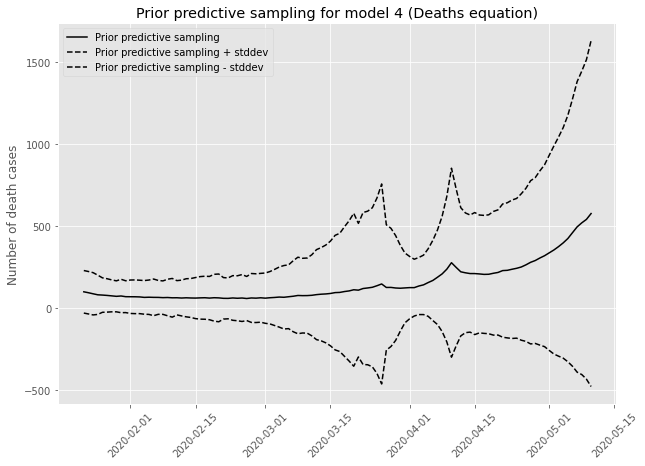

In [0]:
plt.figure(figsize=(10,7))
plt.plot(data[['Date']], y_hat2_prior_predictive_4, color = color_estimated, linestyle="-", linewidth = 1.5)
plt.plot(data[['Date']], y_hat2_prior_predictive_4 + y_std2_prior_predictive_4, color = color_estimated, linestyle="--",linewidth = 1.5)
plt.plot(data[['Date']], y_hat2_prior_predictive_4 - y_std2_prior_predictive_4,color = color_estimated , linestyle= "--",linewidth = 1.5)
plt.xticks(rotation=45)
plt.ylabel('Number of death cases')
plt.legend(["Prior predictive sampling","Prior predictive sampling + stddev","Prior predictive sampling - stddev"])
plt.title('Prior predictive sampling for model 4 (Deaths equation)')
plt.show()

More or less the same can be observed to the death cases where increase and decrease in the graph is something that seems good to capture from data. 

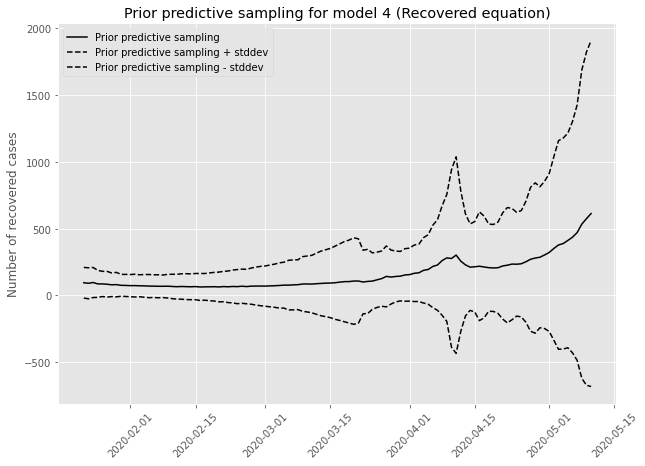

In [0]:
plt.figure(figsize=(10,7))
plt.plot(data[['Date']], y_hat3_prior_predictive_4, color = color_estimated, linestyle="-", linewidth = 1.5)
plt.plot(data[['Date']], y_hat3_prior_predictive_4 + y_std3_prior_predictive_4, color = color_estimated, linestyle="--",linewidth = 1.5)
plt.plot(data[['Date']], y_hat3_prior_predictive_4 - y_std3_prior_predictive_4,color = color_estimated , linestyle= "--",linewidth = 1.5)
plt.xticks(rotation=45)
plt.ylabel('Number of recovered cases')
plt.legend(["Prior predictive sampling","Prior predictive sampling + stddev","Prior predictive sampling - stddev"])
plt.title('Prior predictive sampling for model 4 (Recovered equation)')
plt.show()

For recovered, the prior predictive sampling seems quite similar to the first one. 

#### 3.5.2 Vector autoregression model with changing point

Now, the actual vector autoregssion model is ready to be implemented. 

In [0]:
# define Stan model
vector_reg_change = """
data {
  int<lower=1> T;          // length of the time-series
  int<lower=0> T_forecast; // num. steps ahead to predict
  real y1[T];              // time-series data
  real y2[T];              // time-series data
  real y3[T];              // time-series data
  real<lower=0> beta_val1; // Prior on beta1
  real<lower=0> beta_val2; // Prior on beta2
  real<lower=0> tau_val;   // Prior on tau
  real<lower=0> sig_val;   // Prior on sigma
  real<lower=0> s_C;       // Change point for confirmed cases 
  real<lower=0> s_D;       // Change point for death cases 
  real<lower=0> s_R;       // Change point for recovered cases 

}
 
parameters {
  real beta_state_1 [3,3];        // state transition coefficients
  real beta_state_2 [3,3];        // state transition coefficients
  real<lower=0> tau[3];           // state transition noise
  real<lower=0> sigma[3];         // observation noise
  real<lower=0> z1[T+T_forecast]; // vector of latent states
  real<lower=0> z2[T+T_forecast]; // vector of latent states
  real<lower=0> z3[T+T_forecast]; // vector of latent states
}
 
model {
  for(i in 1:3)
    for(j in 1:3)
      beta_state_1[i,j] ~ normal(0,beta_val1); 
  for(i in 1:3)
    for(j in 1:3)
      beta_state_2[i,j] ~ normal(0,beta_val2); 
  for(i in 1:3)
    tau[i] ~ normal(0,10);        // prior on the variance 
  for(i in 1:3)
    sigma[i] ~ normal(0,sig_val); // prior on the variance
 

  z1[1] ~ normal(0, 10); // fat prior on first state
  z2[1] ~ normal(0, 10); // fat prior on first state
  z3[1] ~ normal(0, 10); // fat prior on first state
 
  for(t in 2:(T+T_forecast)) {

    // State 1
    if (t <=s_C){
      z1[t] ~ normal(beta_state_1[1,1] * z1[t-1] + beta_state_1[1,2] * z2[t-1] + beta_state_1[1,3] * z3[t-1], tau[1]); // latent dynamics
    }
    // State 2
    else {
      z1[t] ~ normal(beta_state_2[1,1] * z1[t-1] + beta_state_2[1,2] * z2[t-1] + beta_state_2[1,3] * z3[t-1], tau[1]); // latent dynamics
    }

    // State 1
    if (t <=s_D){
      z2[t] ~ normal(beta_state_1[2,1] * z1[t-1] + beta_state_1[2,2] * z2[t-1] + beta_state_1[2,3] * z3[t-1], tau[2]); // latent dynamics
    }
    // State 2
    else{
      z2[t] ~ normal(beta_state_2[2,1] * z1[t-1] + beta_state_2[2,2] * z2[t-1] + beta_state_2[2,3] * z3[t-1], tau[2]); // latent dynamics
    }

    // State 1
    if (t <=s_R){
      z3[t] ~ normal(beta_state_1[3,1] * z1[t-1] + beta_state_1[3,2] * z2[t-1] + beta_state_1[3,3] * z3[t-1], tau[3]); // latent dynamics
    }
    // State 2
    else {
      z3[t] ~ normal(beta_state_2[3,1] * z1[t-1] + beta_state_2[3,2] * z2[t-1] + beta_state_2[3,3] * z3[t-1], tau[3]); // latent dynamics
    }
  }
 
  y1[1:T] ~ student_t_lpdf(T -1, z1[1:T], sigma[1]); // likelihood
  y2[1:T] ~ student_t_lpdf(T -1, z2[1:T], sigma[2]); // likelihood
  y3[1:T] ~ student_t_lpdf(T -1, z3[1:T], sigma[3]); // likelihood

}
 
generated quantities {
  vector[T+T_forecast] y_hat1; // vector to store predictions
  vector[T+T_forecast] y_hat2; // vector to store predictions
  vector[T+T_forecast] y_hat3; // vector to store predictions
 
 for (t in 1:(T+T_forecast)) {
    y_hat1[t] <- student_t_rng(T+T_forecast -1, z1[t], sigma[1]); // predictions
    y_hat2[t] <- student_t_rng(T+T_forecast -1, z2[t], sigma[2]); // predictions
    y_hat3[t] <- student_t_rng(T+T_forecast -1, z3[t], sigma[3]); // predictions
 }
}
"""

#### Sensitivity Analysis/ Parameter tuning 

From investigation in the prior predictive sampling values betweel 0 and 1 seemed to work better compared to higher values. Therefore, all kinds of combinations of 0.1 and 1 for each of the four parameters are tried in the parameter tuning. This gives 16 ($2^{4}$) iterations which is compurationally challenging, and it would be ideal in the future to try even more values for further optimizing the model and for example run it on a supercomputer for faster response. 

In [0]:
#We create a mesh grid to iterate over all combinations for sigma, tau and beta
iterArray = np.array(np.meshgrid([0.1,1], [0.1,1], [0.1,1], [0.1,1])).reshape(4,-1)
beta1_model_4 = iterArray[0,:]
beta2_model_4  = iterArray[1,:]
tau_model_4  = iterArray[2,:]
sigma_model_4  = iterArray[3,:]


Below, the model is run for each combination of parameters.

In [0]:
samples_different_values_model_4 = []

for i in range(len(sigma_model_4)):
  print("Iteration {0} out of {1} with parameter values:".format(i+1,len(sigma_model_4)))
  print("sigma: {0}".format(sigma_model_4[i]))
  print("tau: {0}".format(tau_model_4[i]))
  print("beta 1: {0}".format(beta1_model_4[i]))
  print("beta 2: {0}".format(beta2_model_4[i]))

  data_temp_model_4 = {'T': T, 'T_forecast': T_forecast,'y1': y_C,
              'y2': y_D, 'y3': y_R, 'beta_val1': beta1_model_4[i], 
              'beta_val2': beta2_model_4[i], 
              'tau_val': tau_model_4[i], 'sig_val': sigma_model_4[i], 
              's_C': s_C, 's_D':s_D, 's_R':s_R}

  samples_temp_model_4, fit_model_temp_model_4 = fit_the_model(data_temp_model_4, 
                                             vector_reg_change)
  samples_different_values_model_4.append(samples_temp_model_4)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_9ea7235802748e367cdcc377c81920bc NOW.


Iteration 1 out of 16 with parameter values:
sigma: 0.1
tau: 0.1
beta 1: 0.1
beta 2: 0.1


INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_9ea7235802748e367cdcc377c81920bc NOW.


Iteration 2 out of 16 with parameter values:
sigma: 1.0
tau: 0.1
beta 1: 0.1
beta 2: 0.1


INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_9ea7235802748e367cdcc377c81920bc NOW.


Iteration 3 out of 16 with parameter values:
sigma: 0.1
tau: 1.0
beta 1: 0.1
beta 2: 0.1


INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_9ea7235802748e367cdcc377c81920bc NOW.


Iteration 4 out of 16 with parameter values:
sigma: 1.0
tau: 1.0
beta 1: 0.1
beta 2: 0.1


INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_9ea7235802748e367cdcc377c81920bc NOW.


Iteration 5 out of 16 with parameter values:
sigma: 0.1
tau: 0.1
beta 1: 1.0
beta 2: 0.1


INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_9ea7235802748e367cdcc377c81920bc NOW.


Iteration 6 out of 16 with parameter values:
sigma: 1.0
tau: 0.1
beta 1: 1.0
beta 2: 0.1


INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_9ea7235802748e367cdcc377c81920bc NOW.


Iteration 7 out of 16 with parameter values:
sigma: 0.1
tau: 1.0
beta 1: 1.0
beta 2: 0.1


INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_9ea7235802748e367cdcc377c81920bc NOW.


Iteration 8 out of 16 with parameter values:
sigma: 1.0
tau: 1.0
beta 1: 1.0
beta 2: 0.1


INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_9ea7235802748e367cdcc377c81920bc NOW.


Iteration 9 out of 16 with parameter values:
sigma: 0.1
tau: 0.1
beta 1: 0.1
beta 2: 1.0


INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_9ea7235802748e367cdcc377c81920bc NOW.


Iteration 10 out of 16 with parameter values:
sigma: 1.0
tau: 0.1
beta 1: 0.1
beta 2: 1.0


INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_9ea7235802748e367cdcc377c81920bc NOW.


Iteration 11 out of 16 with parameter values:
sigma: 0.1
tau: 1.0
beta 1: 0.1
beta 2: 1.0


INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_9ea7235802748e367cdcc377c81920bc NOW.


Iteration 12 out of 16 with parameter values:
sigma: 1.0
tau: 1.0
beta 1: 0.1
beta 2: 1.0


INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_9ea7235802748e367cdcc377c81920bc NOW.


Iteration 13 out of 16 with parameter values:
sigma: 0.1
tau: 0.1
beta 1: 1.0
beta 2: 1.0


INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_9ea7235802748e367cdcc377c81920bc NOW.


Iteration 14 out of 16 with parameter values:
sigma: 1.0
tau: 0.1
beta 1: 1.0
beta 2: 1.0


INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_9ea7235802748e367cdcc377c81920bc NOW.


Iteration 15 out of 16 with parameter values:
sigma: 0.1
tau: 1.0
beta 1: 1.0
beta 2: 1.0


INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_9ea7235802748e367cdcc377c81920bc NOW.


Iteration 16 out of 16 with parameter values:
sigma: 1.0
tau: 1.0
beta 1: 1.0
beta 2: 1.0


<Figure size 720x720 with 0 Axes>

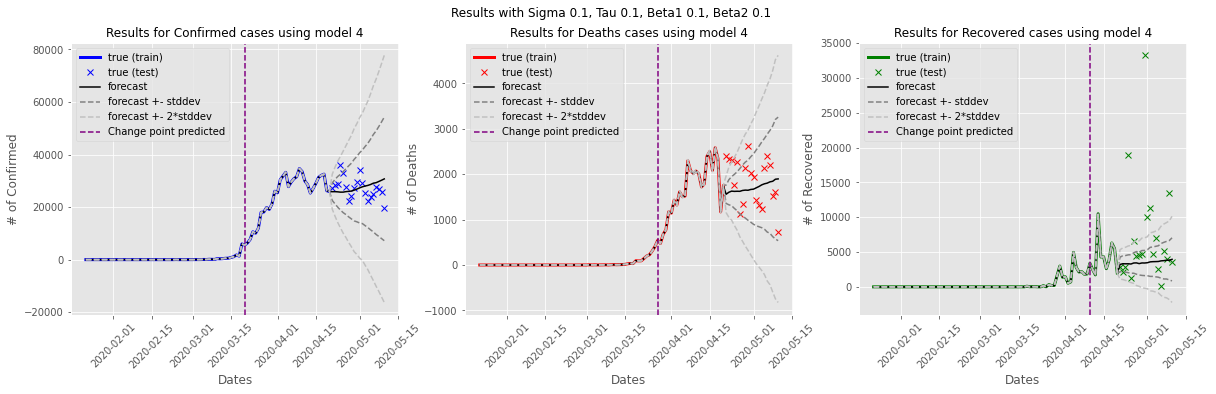

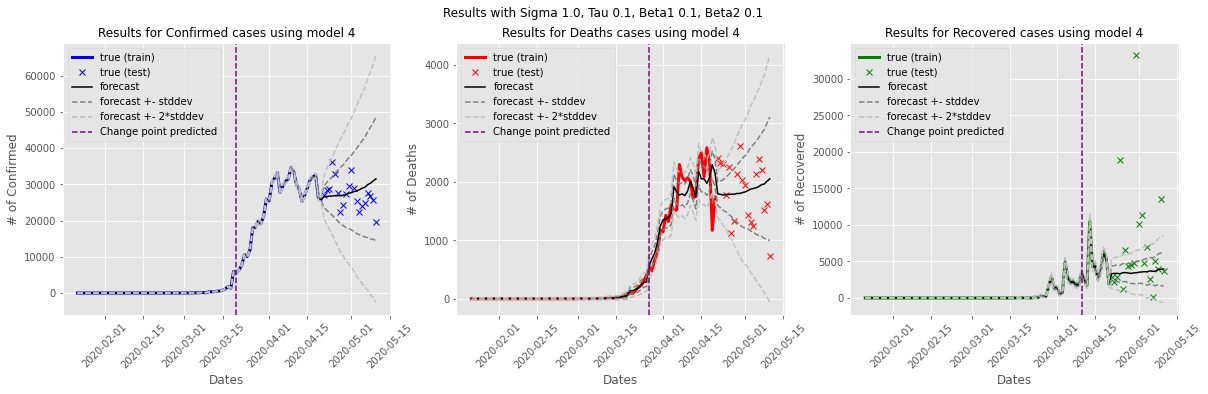

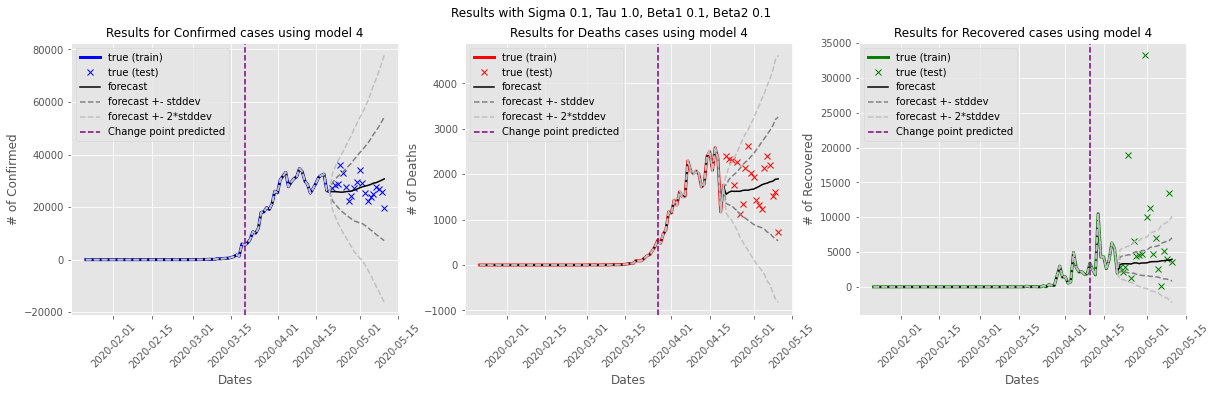

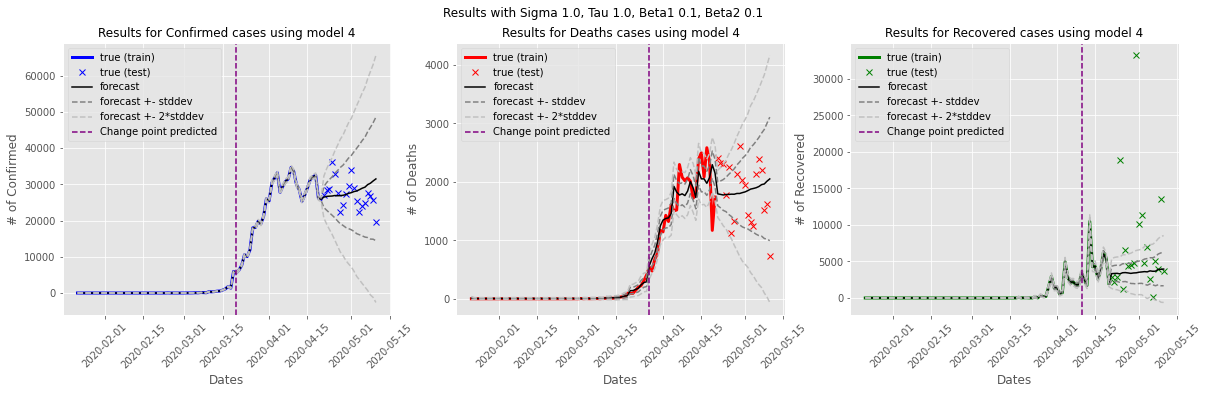

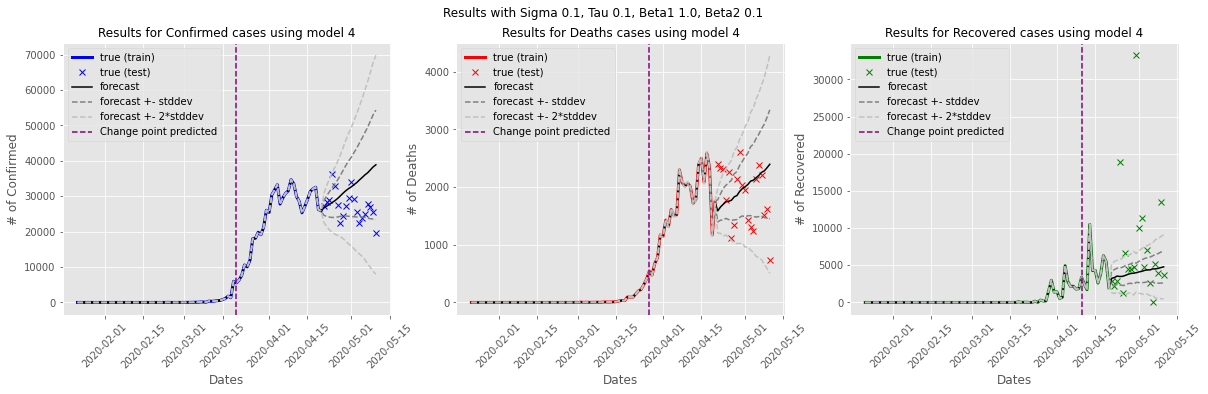

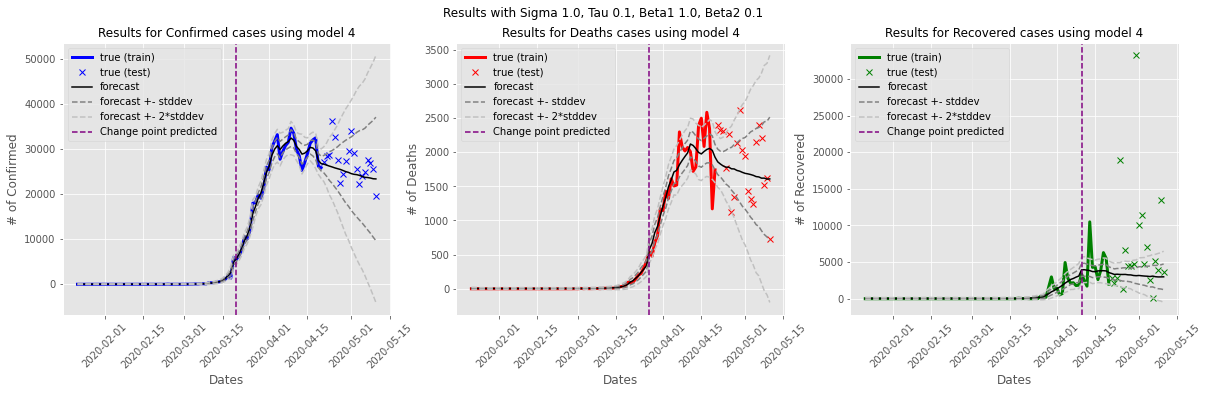

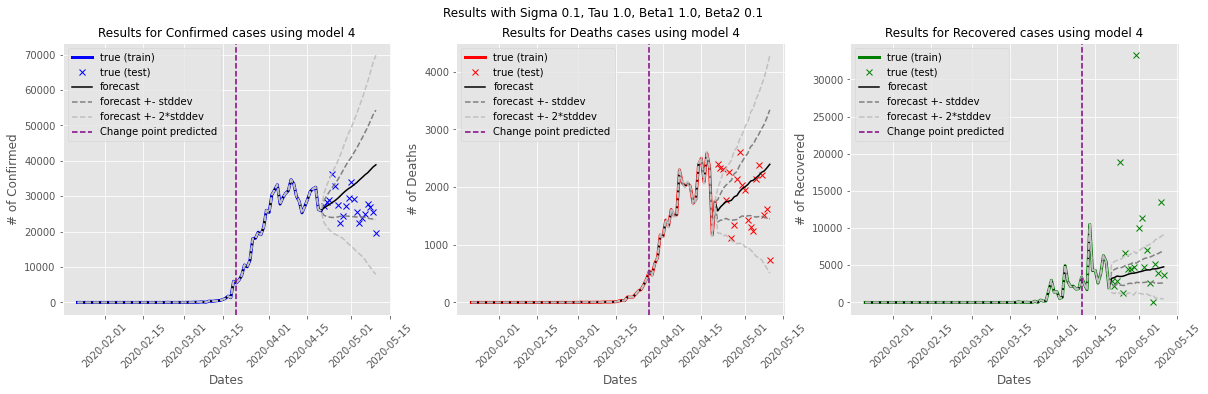

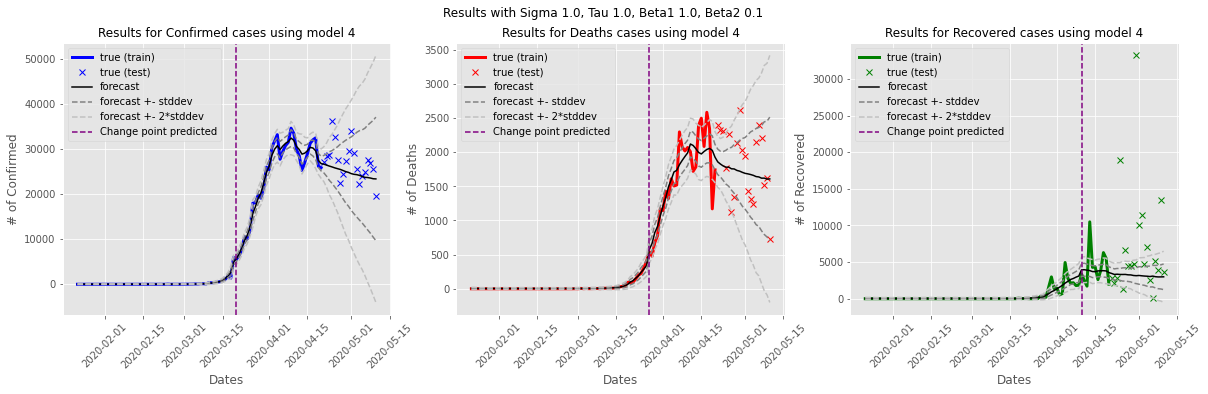

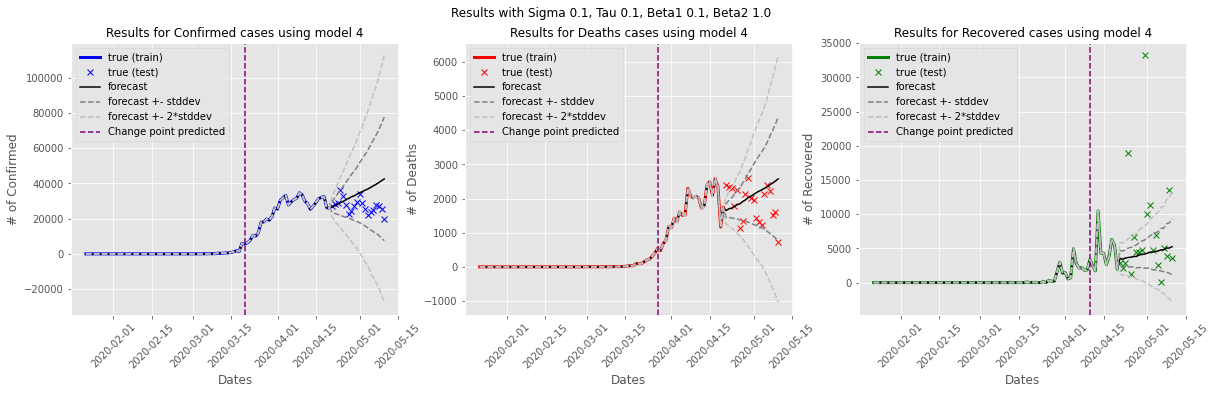

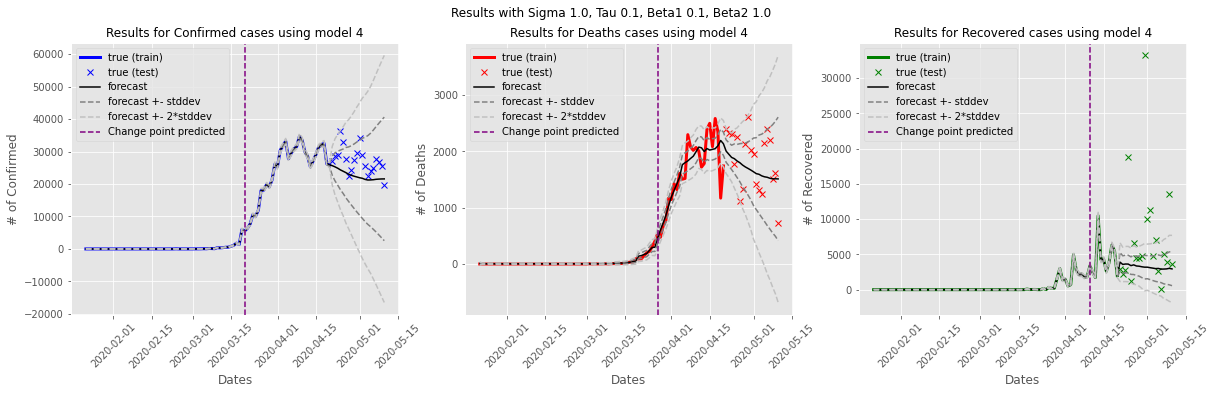

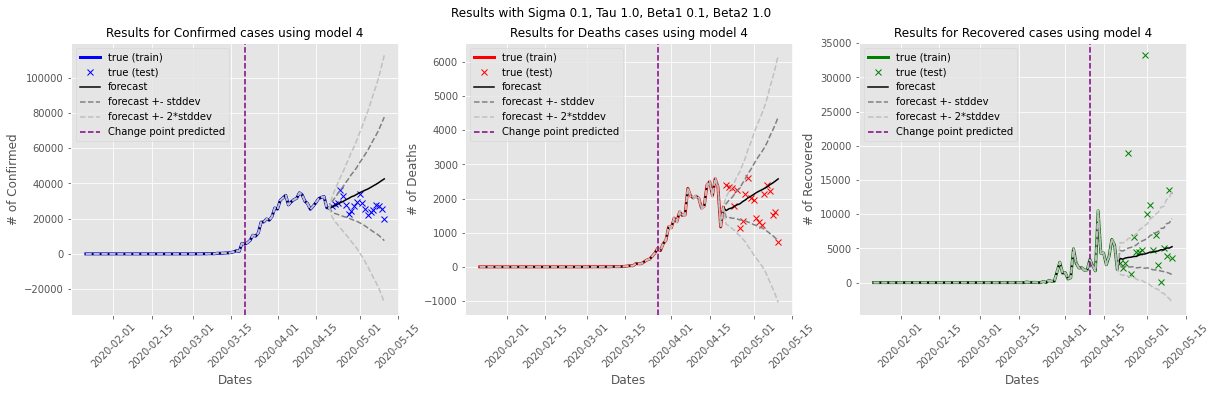

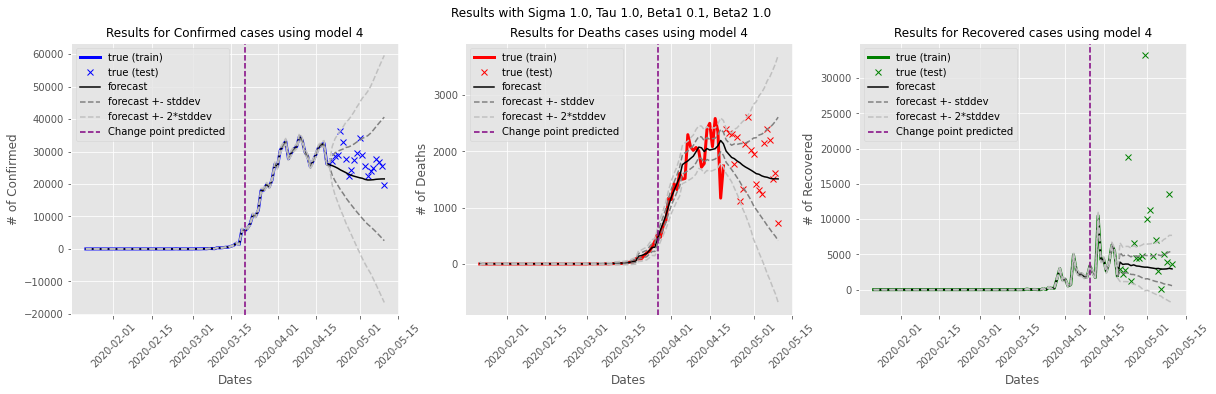

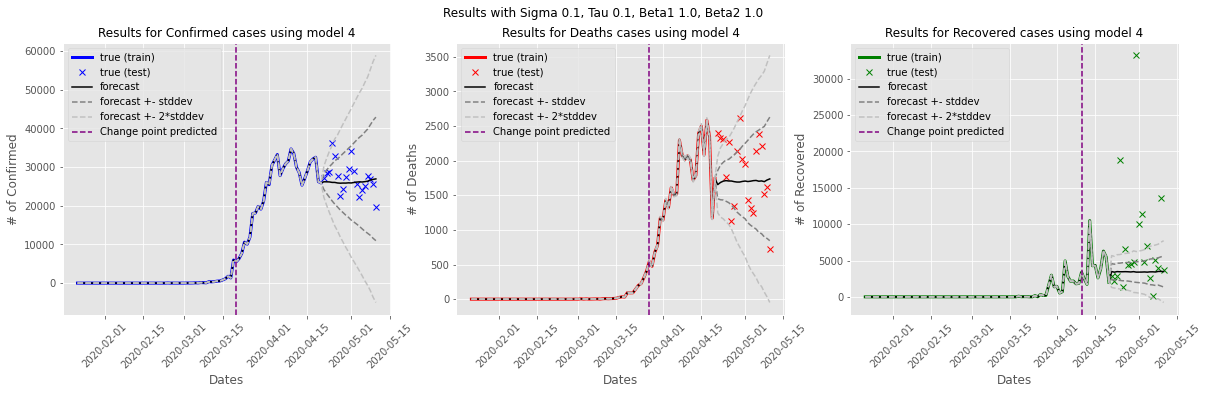

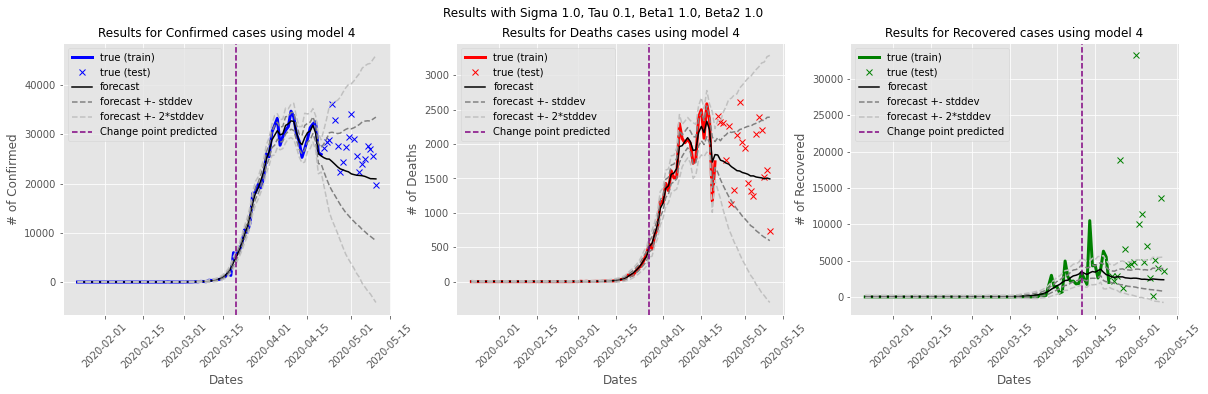

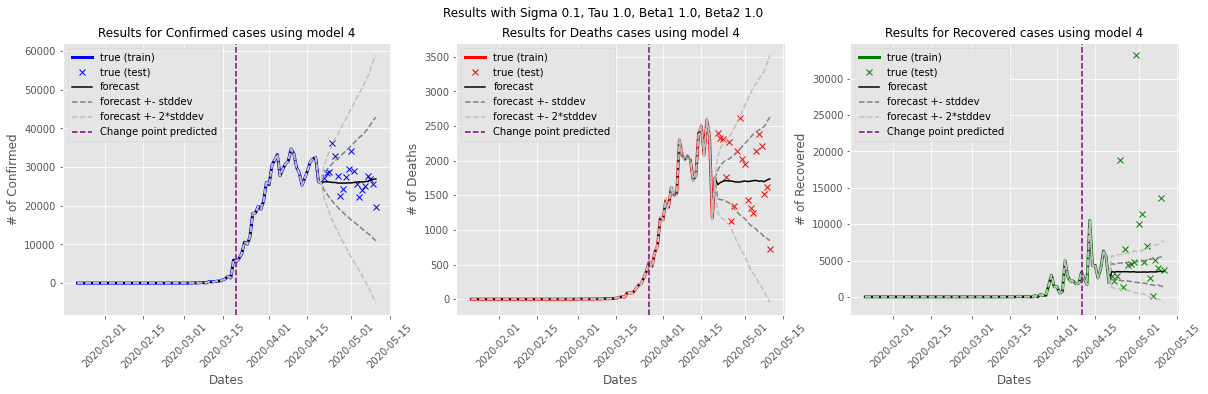

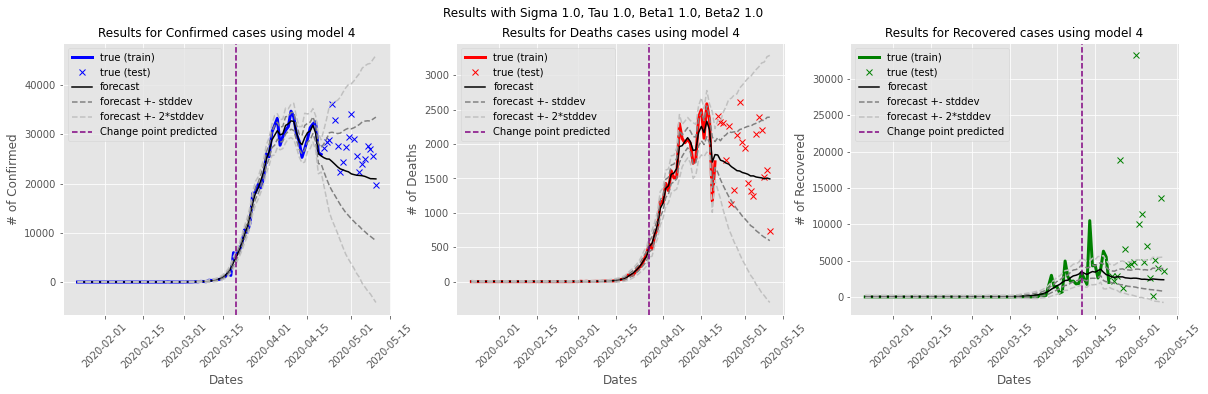

In [0]:
##Confirmed, death and recovered
# new style method 2; use an axes array


plt.figure(figsize=(10,10))  
for i in range(len(sigma_model_4)):

  # get mean and standard devitions for predictions
  y_hatC_model_4_temp = (samples_different_values_model_4[i]["y_hat1"]**2).mean(axis=0)
  y_stdC_model_4_temp = (samples_different_values_model_4[i]["y_hat1"]**2).std(axis=0)
  y_hatD_model_4_temp = (samples_different_values_model_4[i]["y_hat2"]**2).mean(axis=0)
  y_stdD_model_4_temp = (samples_different_values_model_4[i]["y_hat2"]**2).std(axis=0)
  y_hatR_model_4_temp = (samples_different_values_model_4[i]["y_hat3"]**2).mean(axis=0)
  y_stdR_model_4_temp = (samples_different_values_model_4[i]["y_hat3"]**2).std(axis=0)

  # Plot for each combination of parameters
  fig = plt.figure(figsize=(20,5))
  fig.suptitle('Results with Sigma {0}, Tau {1}, Beta1 {2}, Beta2 {3}'.format(sigma_model_4[i],
                                                                                            tau_model_4[i], 
                                                                                            beta1_model_4[i],
                                                                                            beta2_model_4[i]))
  plt.subplot(1,3, 1)  
  plot_results('Confirmed', y_hatC_model_4_temp, y_stdC_model_4_temp, 4,[s_C])
  plt.subplot(1,3, 2)
  plot_results('Deaths', y_hatD_model_4_temp, y_stdD_model_4_temp, 4,[s_D])
  plt.subplot(1,3, 3)
  plot_results('Recovered', y_hatR_model_4_temp, y_stdR_model_4_temp, 4,[s_R])

plt.show()

In [0]:
# Empty arrays for RMSE
MSE_model_4_C = np.zeros(len(sigma_model_4))
MSE_model_4_D = np.zeros(len(sigma_model_4))
MSE_model_4_R = np.zeros(len(sigma_model_4))


for i in range(len(sigma_model_4)):
  # get mean and standard devitions for predictions
  y_hatC_model_4_temp = (samples_different_values_model_4[i]["y_hat1"]**2).mean(axis=0)[:T]
  y_hatD_model_4_temp = (samples_different_values_model_4[i]["y_hat2"]**2).mean(axis=0)[:T]
  y_hatR_model_4_temp = (samples_different_values_model_4[i]["y_hat3"]**2).mean(axis=0)[:T]

  #A similarity measure
  MSE_model_4_C[i] = mean_squared_error((y_train[:,0]), y_hatC_model_4_temp, squared=False)
  
  MSE_model_4_D[i] = mean_squared_error((y_train[:,1]), y_hatD_model_4_temp, squared=False)
  
  MSE_model_4_R[i] = mean_squared_error((y_train[:,2]), y_hatR_model_4_temp, squared=False)


The mininum RMSE is found for each variable of each parameter combination and therefore the optimal solution for conformed might for example not be the optimal solution for recovered, and each of the result has to be assesed both taking the minumum values into account, but also checking them afterwards whether they make sense in the graph structure.

In [0]:
#Confirmed
min_mse_model_4_C = min(MSE_model_4_C)
idx_min_model_4_C = np.argmin(MSE_model_4_C)

beta1_min_model_4_C = beta1_model_4[idx_min_model_4_C]
beta2_min_model_4_C = beta2_model_4[idx_min_model_4_C]

tau_min_model_4_C = tau_model_4[idx_min_model_4_C]
sigma_min_model_4_C= sigma_model_4[idx_min_model_4_C]

# Death
min_mse_model_4_D = min(MSE_model_4_D)
idx_min_model_4_D = np.argmin(MSE_model_4_D)

beta1_min_model_4_D = beta1_model_4[idx_min_model_4_D]
beta2_min_model_4_D = beta2_model_4[idx_min_model_4_D]

tau_min_model_4_D = tau_model_4[idx_min_model_4_D]
sigma_min_model_4_D= sigma_model_4[idx_min_model_4_D]

#Recovered
min_mse_model_4_R = min(MSE_model_4_R)
idx_min_model_4_R = np.argmin(MSE_model_4_R)

beta1_min_model_4_R = beta1_model_4[idx_min_model_4_R]
beta2_min_model_4_R = beta2_model_4[idx_min_model_4_R]

tau_min_model_4_R = tau_model_4[idx_min_model_4_R]
sigma_min_model_4_R= sigma_model_4[idx_min_model_4_R]

An overview over the minimum RMSE found for each variable and their corresponding parameter values.

In [0]:
print('Confirmed')
print("Beta 1: {0}".format(beta1_min_model_4_C))
print("Beta 2: {0}".format(beta2_min_model_4_C))
#print("Beta 3: {0}".format(beta3_min_model_4_C))

print("Tau: {0}".format(tau_min_model_4_C))
print("Sigma {0}".format(sigma_min_model_4_C))
print('---------------------')
print('Deaths')
print("Beta 1: {0}".format(beta1_min_model_4_D))
print("Beta 2: {0}".format(beta2_min_model_4_D))

print("Tau: {0}".format(tau_min_model_4_D))
print("Sigma {0}".format(sigma_min_model_4_D))
print('---------------------')
print('Recovered')
print("Beta 1: {0}".format(beta1_min_model_4_R))
print("Beta 2: {0}".format(beta2_min_model_4_R))

print("Tau: {0}".format(tau_min_model_4_R))
print("Sigma {0}".format(sigma_min_model_4_R))

Confirmed
Beta 1: 0.1
Beta 2: 0.1
Tau: 0.1
Sigma 0.1
---------------------
Deaths
Beta 1: 0.1
Beta 2: 0.1
Tau: 0.1
Sigma 0.1
---------------------
Recovered
Beta 1: 1.0
Beta 2: 0.1
Tau: 0.1
Sigma 0.1


Assesing these outputs, gave two identical parameter sets both for confirmed and death cases. Looking at the graphs, we can see that the model seems to provide a very good fit for the train data. Therefore, this parameter set will be chosen as the best set so far, but could be optimized even further as discussed earlier. 

#### Results for model 4

In [0]:
beta1_best = 0.1
beta2_best = 0.1
tau_best=0.1
sigma_best=0.1


In [0]:
Best_val_model_4 = {'T': len(y_train), 'T_forecast': T_forecast,'y1': y_C,
                    'y2': y_D, 'y3': y_R, 'beta_val1': beta1_best, 'beta_val2': beta2_best,
                    'tau_val': tau_best, 'sig_val': sigma_best, 
                    's_C': s_C, 's_D':s_D, 's_R':s_R}
                          

In [0]:
samples_best_model_4 , fit_best_model_4  = fit_the_model(Best_val_model_4 , 
                                             vector_reg_change)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_9ea7235802748e367cdcc377c81920bc NOW.


In [0]:
y_hatC_model_4 = (samples_best_model_4["y_hat1"]**2).mean(axis=0)
y_stdC_model_4 = (samples_best_model_4["y_hat1"]**2).std(axis=0)
y_hatD_model_4 = (samples_best_model_4["y_hat2"]**2).mean(axis=0)
y_stdD_model_4 = (samples_best_model_4["y_hat2"]**2).std(axis=0)
y_hatR_model_4 = (samples_best_model_4["y_hat3"]**2).mean(axis=0)
y_stdR_model_4 = (samples_best_model_4["y_hat3"]**2).std(axis=0)

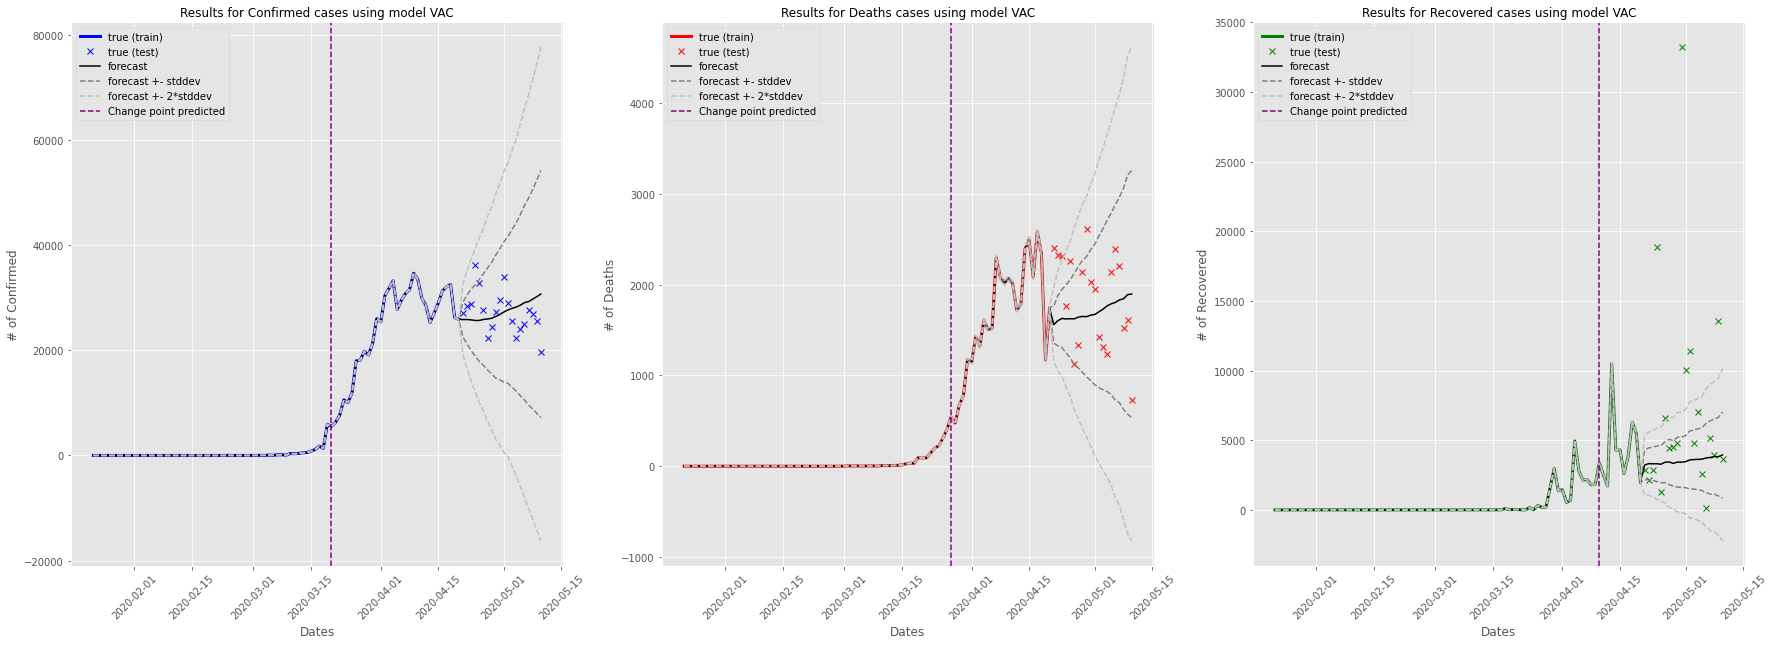

In [0]:
plt.figure(figsize=(30,10))  
plt.subplot(1,3, 1)  
plot_results('Confirmed', y_hatC_model_4, y_stdC_model_4, 'VAC',[s_C])
plt.subplot(1,3, 2)
plot_results('Deaths', y_hatD_model_4, y_stdD_model_4, 'VAC',[s_D])
plt.subplot(1,3, 3)
plot_results('Recovered', y_hatR_model_4, y_stdR_model_4, 'VAC',[s_R])

For a student t distribution, around 95.5% of the data is supposed to lie within two standard deviations if it resembles a normal distribution and this is definitly true for confirmed cases, where for the deaths cases there are 10% found outside two standard deviation. For the recovered cases the model seems to have even more difficulties in capturing the data, but there are also two datapoints that are very high around mid April and at the beginning of May. It could actually be the case that they should have been considered as outliers. \\
In general, the test data also seems to fluctuate much more compared to the train data and the model fits very well on the train data, which might even have been a too good fit, making it more difficult to capture the fluctuating test data. This can also be seen from the hyper parameter tuning, were a very good fit on the train data is not necessarily providing the best fit for the test data. However, the fit is evaluated from the train data, but the fit on the test data should afterwards also be assesed.

In [0]:
print(fit_best_model_4)

Inference for Stan model: anon_model_9ea7235802748e367cdcc377c81920bc.
4 chains, each with iter=500; warmup=250; thin=1; 
post-warmup draws per chain=250, total post-warmup draws=1000.

                    mean se_mean     sd    2.5%     25%    50%    75%  97.5%  n_eff   Rhat
beta_state_1[1,1]   0.56  5.8e-3    0.1    0.36     0.5   0.56   0.63   0.74    271   1.02
beta_state_1[2,1]   0.15  9.9e-4   0.02    0.12    0.14   0.15   0.16   0.18    249   1.02
beta_state_1[3,1]   0.15  4.4e-3   0.03     0.1    0.13   0.15   0.17   0.21     45   1.08
beta_state_1[1,2]   0.08  5.4e-3    0.1   -0.11    0.01   0.08   0.14   0.27    325   1.02
beta_state_1[2,2]   0.05  5.9e-3   0.09   -0.14   -0.01   0.05   0.11   0.22    227   1.03
beta_state_1[3,2]   0.11    0.01    0.1   -0.08    0.04   0.11   0.18   0.32     85   1.06
beta_state_1[1,3]   0.06  8.6e-3    0.1   -0.16   -0.01   0.07   0.12   0.25    144   1.01
beta_state_1[2,3]   0.06  4.2e-3   0.08   -0.09  4.3e-3   0.06   0.11   0.21    367   

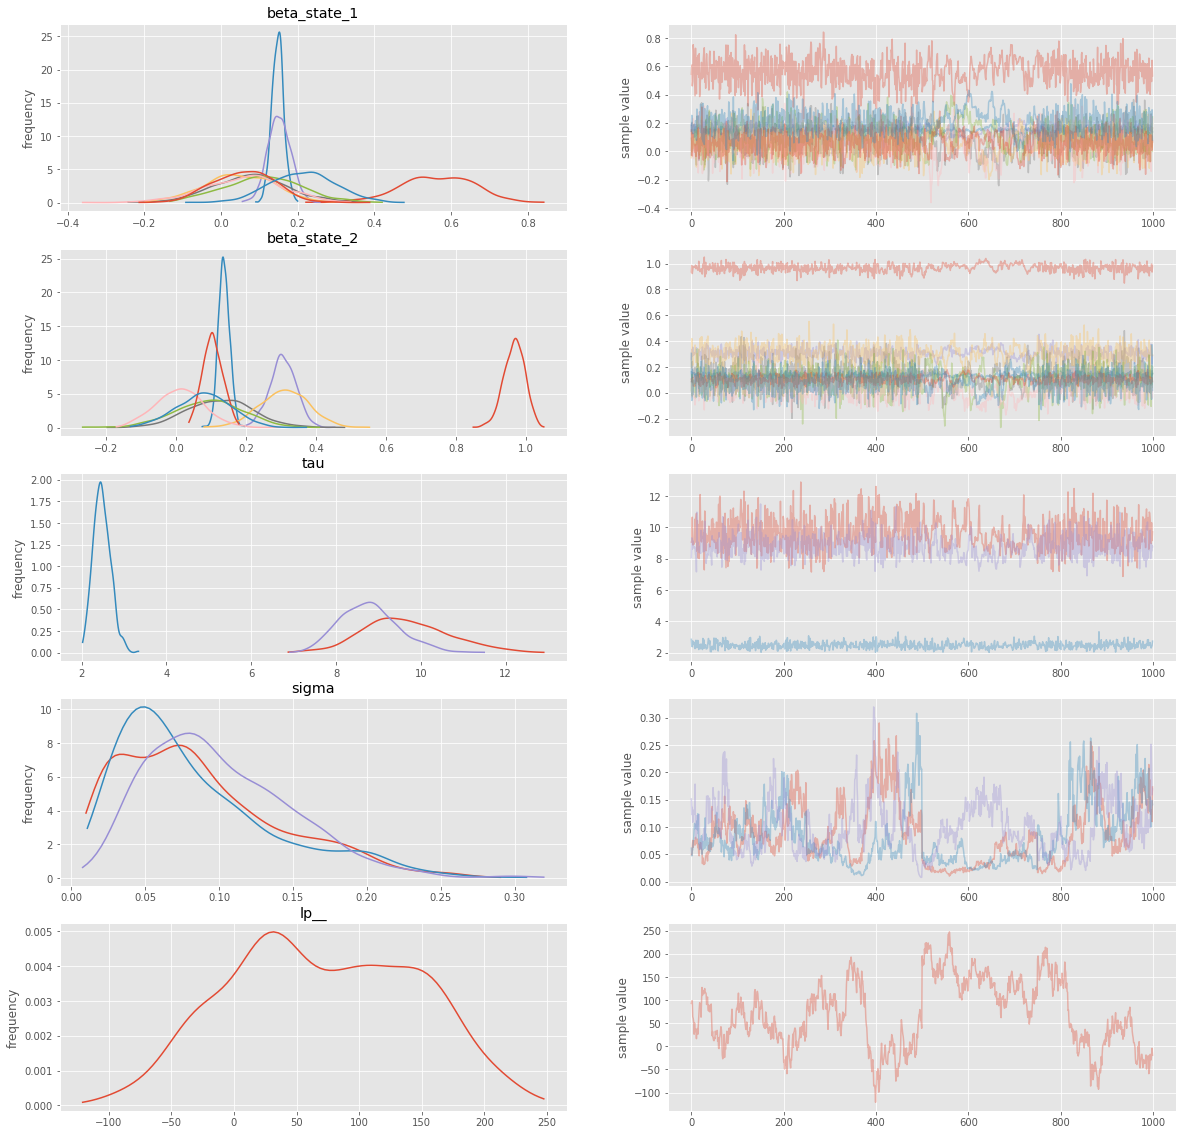

In [0]:
fit_best_model_4.plot(["beta_state_1","beta_state_2","tau","sigma","lp__"])
plt.show()

The samples seems to be more or less randomly distributes as required and have definitly improved from the prior predictive sampling where no parameter sensitivity was used to obtain the parameters. In further development, the sampling here for sigma should be considered to be in particular optimized.

The comparison measurement is assesed with using the root mean squared error for each variable on the train data and afterwards the test data.

In [0]:
# get mean and standard devitions for predictions
y_hatC_model_4_train = (samples_best_model_4["y_hat1"]**2).mean(axis=0)[:T]
y_hatD_model_4_train = (samples_best_model_4["y_hat2"]**2).mean(axis=0)[:T]
y_hatR_model_4_train = (samples_best_model_4["y_hat3"]**2).mean(axis=0)[:T]

In [0]:
RMAE_model_4_C = mean_squared_error((y_train[:,0]), y_hatC_model_4_train, squared=False)
print('The Root Mean Squared Error result for Confirmed in Model 4 is {0}'.format(RMAE_model_4_C.round(2)))

The Root Mean Squared Error result for Confirmed in Model 4 is 0.8


In [0]:
RMAE_model_4_D = mean_squared_error((y_train[:,1]), y_hatD_model_4_train, squared=False)
print('The Root Mean Squared Error result for Deaths in Model 4 is {0}'.format(RMAE_model_4_D.round(2)))

The Root Mean Squared Error result for Deaths in Model 4 is 0.38


In [0]:
RMAE_model_4_R = mean_squared_error((y_train[:,2]), y_hatR_model_4_train, squared=False)
print('The Root Mean Squared Error result for Recovered in Model 4 is {0}'.format(RMAE_model_4_R.round(2)))

The Root Mean Squared Error result for Recovered in Model 4 is 0.36


Overall the RMSE have very low values for each variable, which is not suprising since we saw that the model fitted well on the train data. The RMSE is best for the deaths equation but this was also what we selected for earlier from the hyper parameter tuning. 

In [0]:
# get mean and standard devitions for predictions
y_hatC_model_4_test = (samples_best_model_4["y_hat1"]**2).mean(axis=0)[T:]
y_hatD_model_4_test = (samples_best_model_4["y_hat2"]**2).mean(axis=0)[T:]
y_hatR_model_4_test = (samples_best_model_4["y_hat3"]**2).mean(axis=0)[T:]

In [0]:
RMAE_model_4_C_test = mean_squared_error((y_test[:,0]), y_hatC_model_4_test, squared=False)
print('The Root Mean Squared Error result for Confirmed in Model 4 is {0}'.format(RMAE_model_4_C_test.round(2)))

The Root Mean Squared Error result for Confirmed in Model 4 is 4922.04


In [0]:
RMAE_model_4_D_test = mean_squared_error((y_test[:,1]), y_hatD_model_4_test, squared=False)
print('The Root Mean Squared Error result for Deaths in Model 4 is {0}'.format(RMAE_model_4_D_test.round(2)))

The Root Mean Squared Error result for Deaths in Model 4 is 571.01


In [0]:
RMAE_model_4_R_test = mean_squared_error((y_test[:,2]), y_hatR_model_4_test, squared=False)
print('The Root Mean Squared Error result for Confirmed in Model 4 is {0}'.format(RMAE_model_4_R_test.round(2)))

The Root Mean Squared Error result for Confirmed in Model 4 is 8301.77


Overall, all three RMSE scores are lower for all variables for Model 4 (VAC) compared to model 3 (VA). 

#### Conclusion for model 4



A final autoregression model, with all variables (confirmed, deaths, recovered) was developed, and in addition a change point predictor model was constructed initially to obtain the time s, where the data seems to change state. It can be understood as having a rate (early) before this changing point and another rate (late) after this changing point. 

</br>

The change point predictor found one changing point for each of the variables, where it was the 20th of March for confirmed, the 27th of March for deaths and April 10th for recovered. This corresponded well with the data and articles stating increase of cases at these dates, but it was still too early to detect a second change point, since the data is not descreasing enough at the end. 

</br>

A prior predictive sampling was first implemented in order to check for model structures, and after some modifications, the model was restricted to contain only positive values. It was also describing patterns of spikes with increase and decrease, which we found to be suitable for desciribing this data. 

</br>

Hyperparameter tuning was carried to model each combination of parameters and at the end the minimum values of RMSE was used for each variable to check the overall analysis. At the end, the best fit for confirmed and deaths cases was not found to be the best fit for recovered cases. However, this parameter was chosen anyway based on graphical structure as well as the low RSME score. 

</br>

Overall, the vector autoregression model with change point worked well to predict the spread of coronavirus in the USA for confirmed, deaths and recovered even though it could be improved further, in particular for the recovered case. This project, also had to put an end date for the input of corona data, but it could be executed and updated with newer data to further optimise and predict the cases of corona virus. Then, a second changing point might also be found since the pandemic is expected to decrease more in the nearest future.